# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/sesha/OneDrive/Desktop/IMP/before/MINIPJ/Personal/AMAZON food review dataset/database.sqlite')  

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3513.15it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [24]:
print(len(preprocessed_reviews))
final.shape

4986


(4986, 10)

<h2><font color='black'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:00<00:00, 5218.33it/s]


In [26]:
preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,preprocessed_summary)] 
print(preprocessed_reviews[1500])

wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order reviewing mistakes cookies


In [27]:
final ['CleanText']= preprocessed_reviews
final.head(5)

Id   ProductId          UserId                   ProfileName  \
2546  2774  B00002NCJC  A196AJHU9EASJN                  Alex Chaffee   
2547  2775  B00002NCJC  A13RRPGE79XFFH                      reader48   
1145  1244  B00002Z754  A3B8RCEI0FXFI6                     B G Chase   
1146  1245  B00002Z754  A29Z5PI9BW2PU3                        Robbie   
2942  3204  B000084DVR  A1UGDJP1ZJWVPF  T. Moore "thoughtful reader"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2546                     0                       0      1  1282953600   
2547                     0                       0      1  1281052800   
1145                    10                      10      1   962236800   
1146                     7                       7      1   961718400   
2942                     1                       1      1  1177977600   

                             Summary  \
2546                   thirty bucks?   
2547                    Flies Begone   
1145  WOW Make your own 'slickers' !   
1146                   Great Product   
2942                     Good stuff!   

                                                   Text  \
2546  Why is this $[...] when the same product is av...   
2547  We have used the Victor fly bait for 3 seasons...   
1145  I just received my shipment and could hardly w...   
1146  This was a really good idea and the final prod...   
2942  I'm glad my 45lb cocker/standard poodle puppy ...   

                                              CleanText  
2546  product available victor traps unreal course t...  
2547  used victor fly bait seasons ca not beat great...  
1145  received shipment could hardly wait try produc...  
1146  really good idea final product outstanding use...  
2942  glad cocker standard poodle puppy loves stuff ...

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13349)
the number of unique words  13349


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3322)
the number of unique words including both unigrams and bigrams  3322


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'acceptable']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3322)
the number of unique words including both unigrams and bigrams  3322


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.986720621585846), ('excellent', 0.9831117987632751), ('definitely', 0.9783042669296265), ('snack', 0.9761526584625244), ('value', 0.9744237661361694), ('anyone', 0.9710094928741455), ('alternative', 0.9709190130233765), ('regular', 0.9708253741264343), ('tasty', 0.9696333408355713), ('deal', 0.9693977236747742)]
[('hands', 0.9992436170578003), ('varieties', 0.9988967180252075), ('cracker', 0.9986671805381775), ('eaten', 0.99858158826828), ('addicted', 0.9985790252685547), ('jalapeno', 0.9985631704330444), ('sauces', 0.9985266923904419), ('cafe', 0.9985195398330688), ('dinner', 0.9984713196754456), ('popcorn', 0.9984709024429321)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3977
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'bucks', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'wow', 'make', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1393.33it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:19<00:00, 253.93it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [37]:
#Applying KMeans for different values of K
from sklearn.cluster import KMeans

k_vals=range(2,50,5) #initial value =2, Last value =50 with a skip of 5....eg:2,7,13.....
inertia_bow = []
for i in tqdm(k_vals):
    km = KMeans(n_clusters=i)
    km.fit(final_counts)
    inertia_bow.append(km.inertia_)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:42<00:00, 37.24s/it]


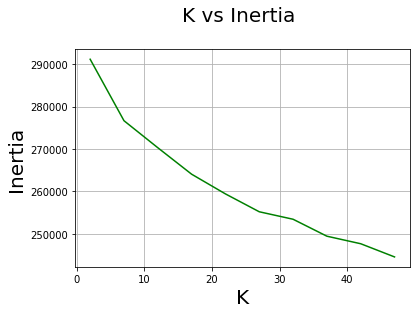

In [38]:
#Graph between K and Inertia

plt.plot(k_vals,inertia_bow,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

Using Elbow Method we can say that optimal alue of K is 7. Therefore we have 7 different clusters.

In [39]:
optimal_k = 7
km= KMeans(n_clusters=optimal_k).fit(final_counts)

In [40]:
# For word clouds 
cluster = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    cluster[km.labels_[i]].append(preprocessed_reviews[i])

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

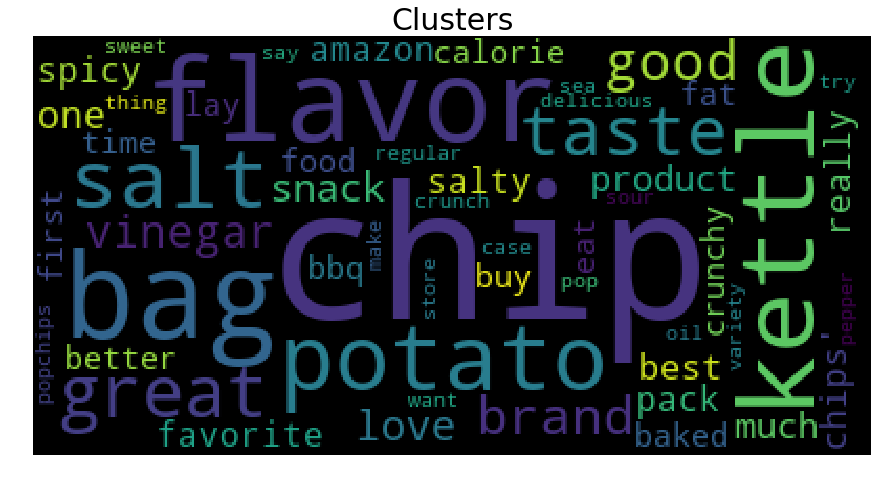

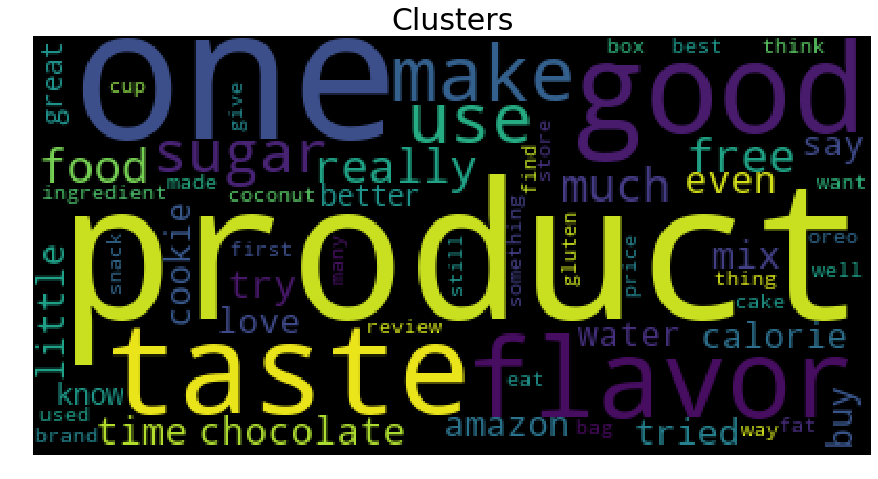

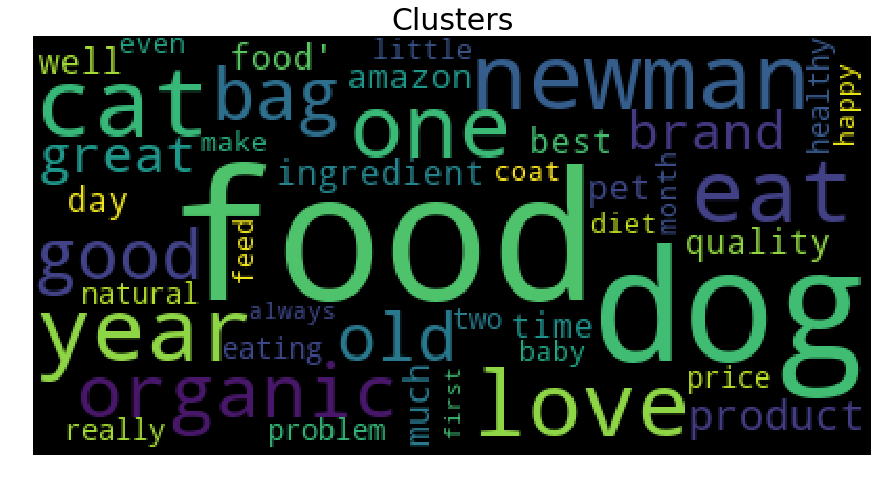

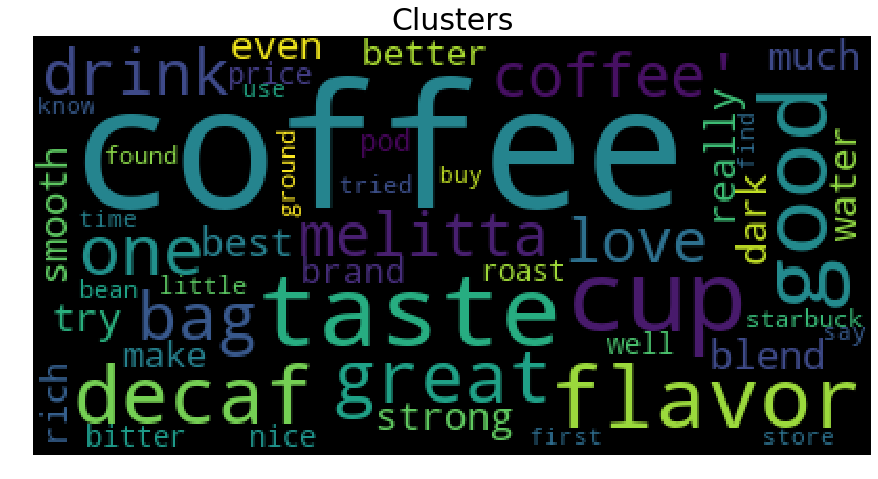

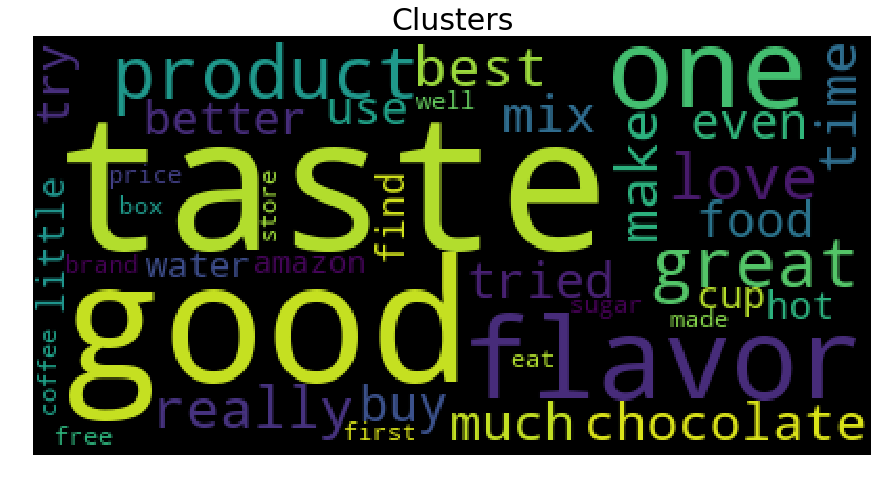

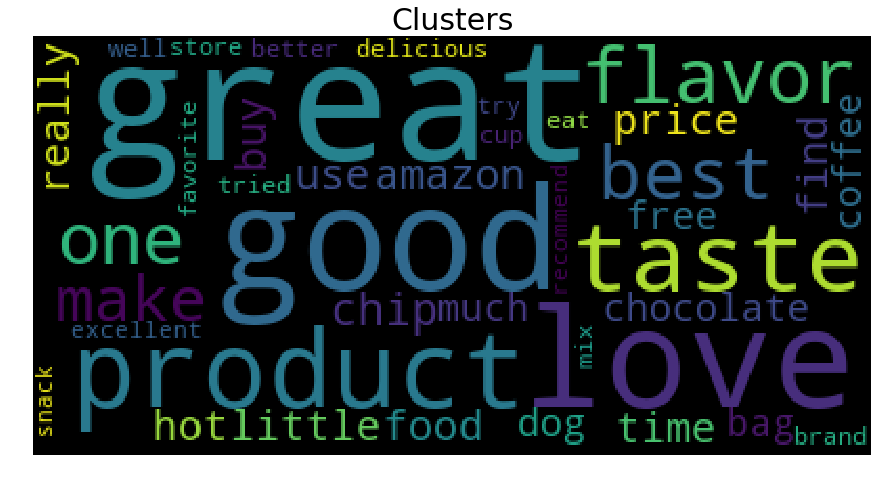

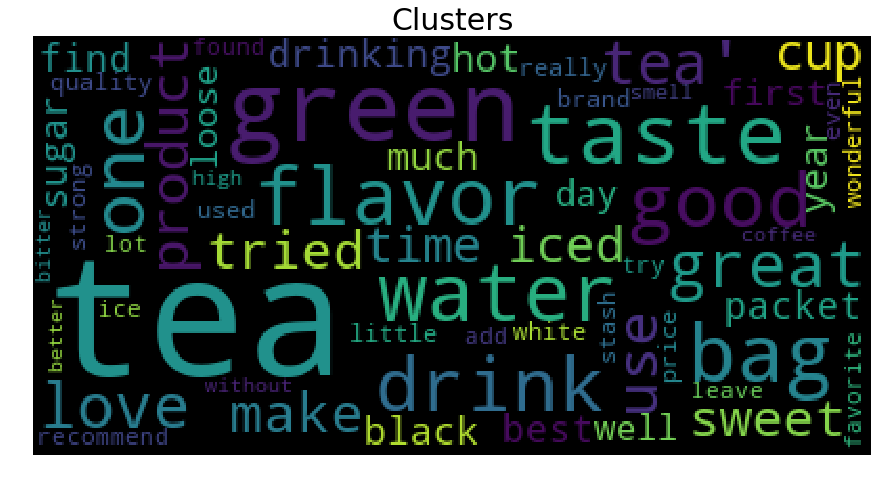

In [41]:
# Please write all the code with proper documentation
from wordcloud import WordCloud

def cloud(clusters):
    wordcloud = WordCloud(collocations=False, background_color ='black', 
                    min_font_size = 10).generate(str(list(clusters)))
    plt.figure(figsize = (12,12), facecolor = None) 
    plt.imshow(wordcloud) #imshow = to display an image 
    plt.axis("off") 
    plt.tight_layout(pad = 0) #tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
    plt.title("Clusters",size= 30,)
    plt.show() 
for cls in cluster:
    cloud(cls)

# Observations

1.First cluster has words like chip, flavor, salt potato, taste etc so,we can say that the first cluster belongs to Chips and its flavors.

2.Second cluster has words like gluten, pancake, waffle, biscuit etc so,we can say that the second cluster belongs to types of  Bakery items.

3.Third cluster has words like coffee, cup, strong, smooth etc so,we can say that the third cluster belongs to coffee and its flavors.

4.Fourth cluster has words like cookie, chocolate, great, product etc so,we can say that the fourth cluster belongs to 'How great or good are the cookies etc'.

5.Fifth cluster has words like tea, sweet, bag, iced etc so,we can say that the fifth cluster belongs to tea.

6.Sixth cluster has words like chocolate, cocoa, hot, milk etc so,we can say that the sixth cluster belongs to chocolate.

7.Seventh cluster has words like dog, cat, love, food etc so,we can say that the seventh cluster belongs to pet's food.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [42]:
# Please write all the code with proper documentation
k_vals = list(range(2, 50,5))
inertia_tfidf = []
for i in tqdm(k_vals):
    km = KMeans(n_clusters=i)
    km.fit(final_tf_idf)
    inertia_tfidf.append(km.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:40<00:00, 40.83s/it]


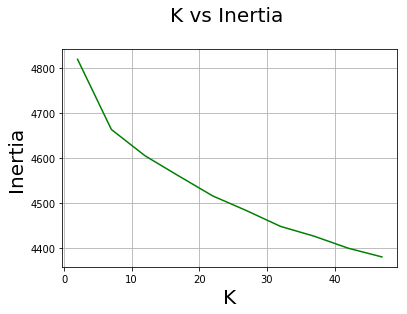

In [44]:
plt.plot(k_vals,inertia_tfidf,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

Using Elbow Method we can say that optimal alue of K is 7. Therefore we have 7 different clusters.

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

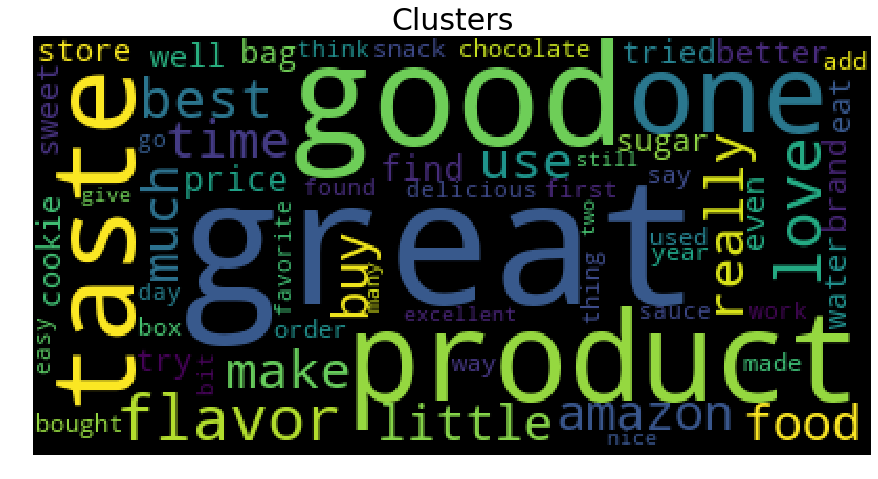

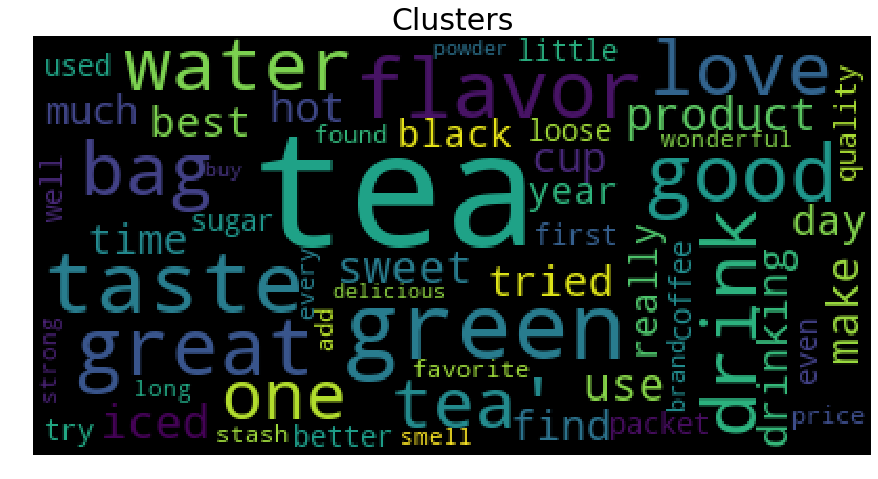

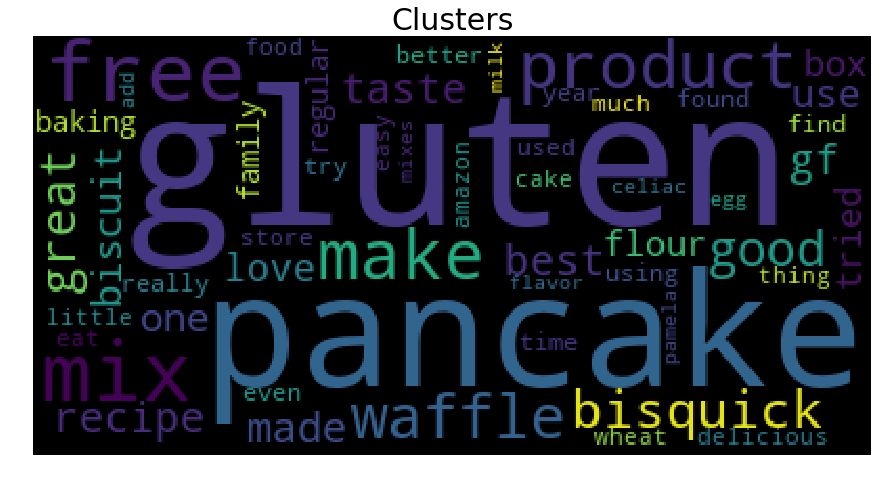

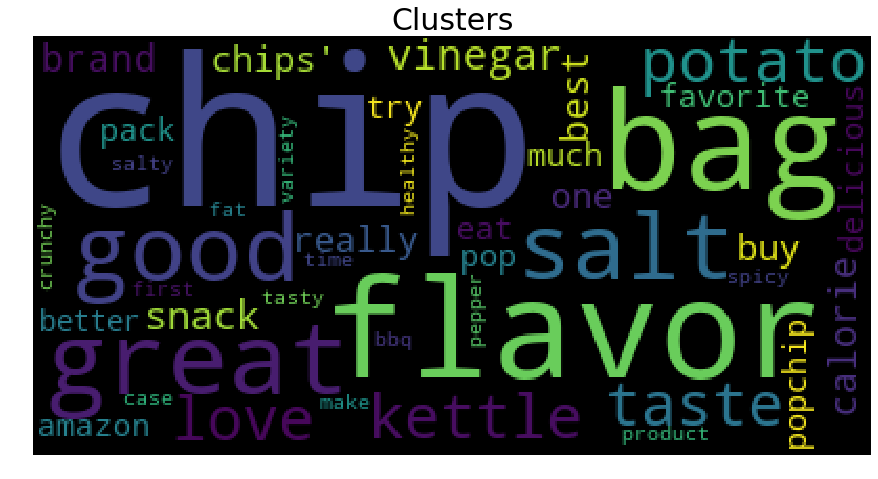

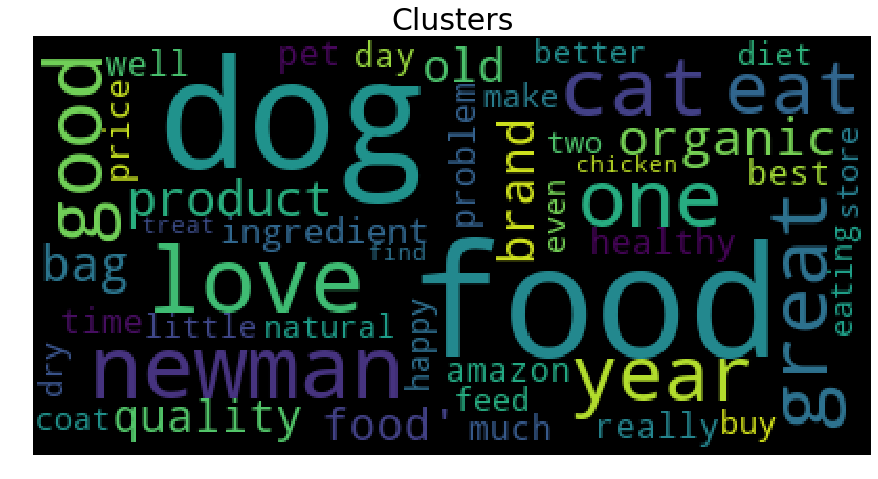

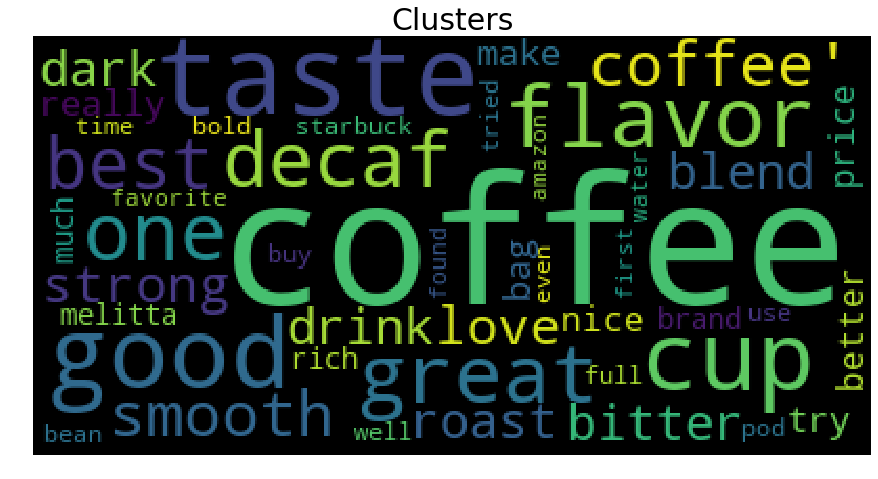

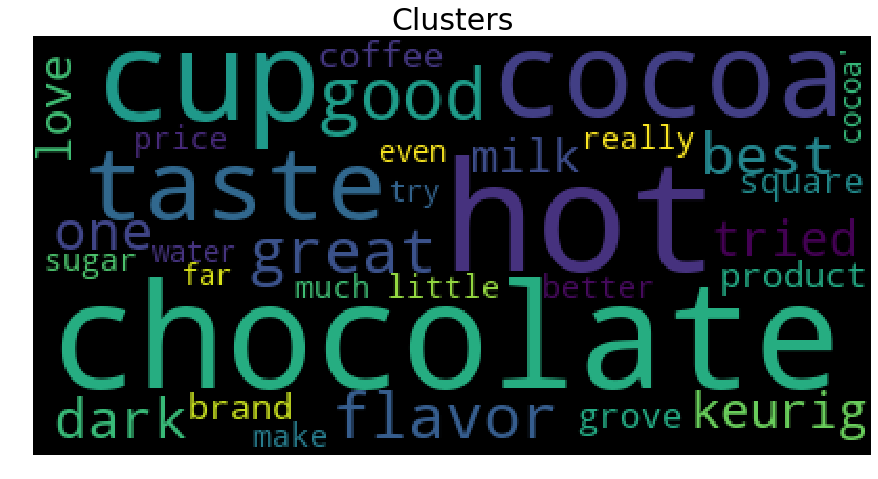

In [45]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit(final_tf_idf)
clust_tfidf = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_tfidf[km.labels_[i]].append(preprocessed_reviews[i])
for cls in clust_tfidf:
    cloud(cls)

# Observations

1.First cluster has words like great, product,flavor, good etc so,we can say that the first cluster belongs 'Compliments for a good product'.

2.Second cluster has words like gluten, free, pancake, biscuit etc so,we can say that the second cluster belongs to types of  Bakery items.

3.Third cluster has words like tea, green, bag, iced etc so,we can say that the third cluster belongs to tea and its flavors.

4.Fourth cluster has words like coffee, taste, dark, decaf etc so,we can say that the fourth cluster belongs to coffee and its varieties.

5.Fifth cluster has words like dog, love, food, organic etc so,we can say that the fifth cluster belongs to pet's food.

6.Sixth cluster has words like chocolate, cocoa, hot, milk etc so,we can say that the sixth cluster belongs to chocolate.

7.Seventh cluster has words like chip, bag, taste, flavor etc so,we can say that the seventh cluster belongs to chips.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [46]:
# Please write all the code with proper documentation
k_vals = list(range(2, 50,5))
inertia_w2v = []
for i in tqdm(k_vals):
    km = KMeans(n_clusters=i)
    km.fit(sent_vectors)
    inertia_w2v.append(km.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  2.31s/it]


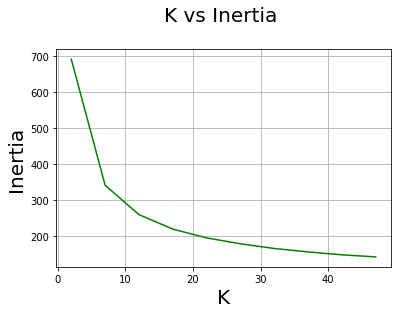

In [47]:
plt.plot(k_vals,inertia_w2v,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

Using Elbow Method we can say that optimal alue of K is 7. Therefore we have 7 different clusters.

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

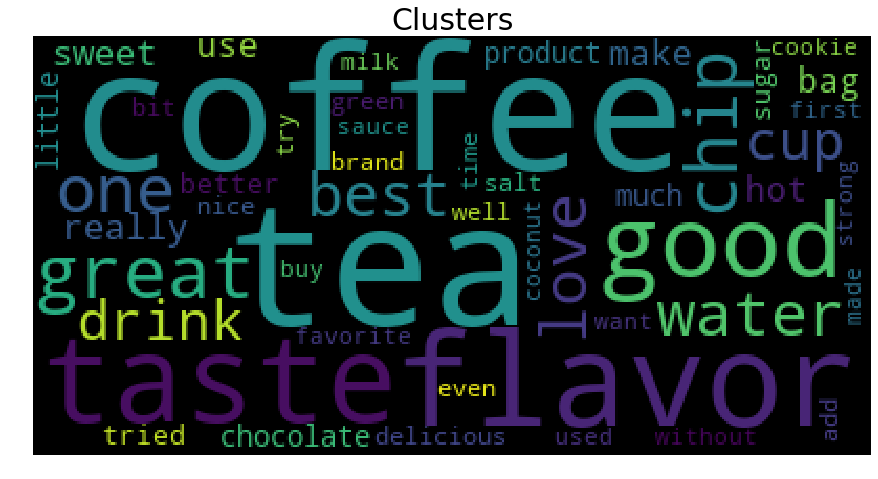

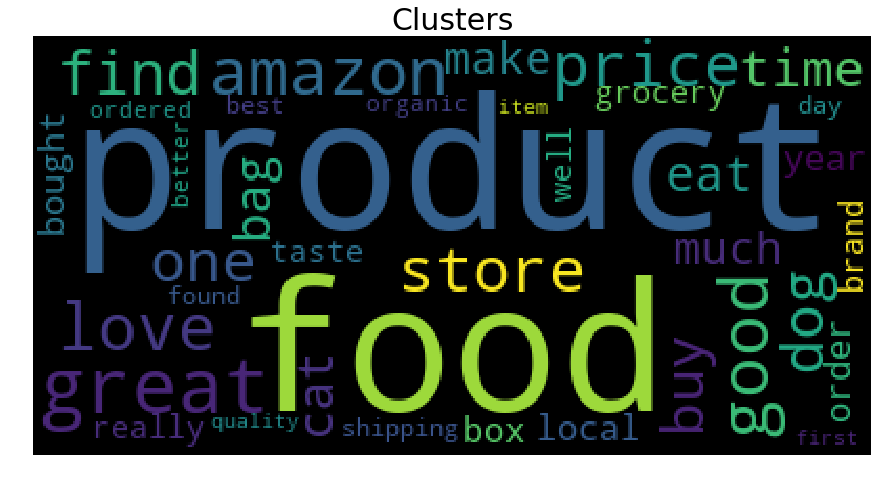

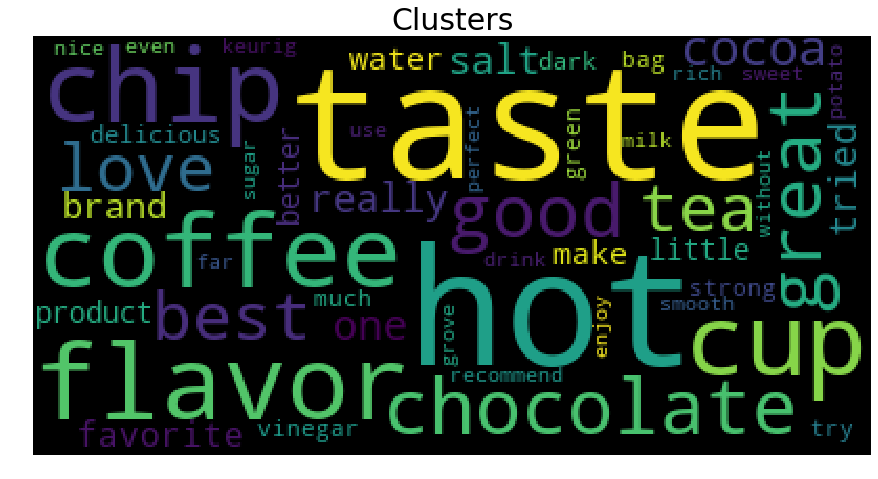

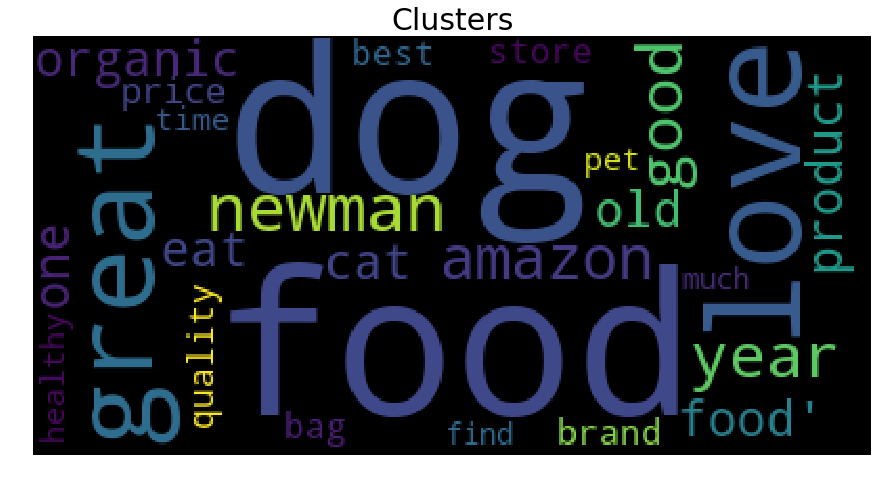

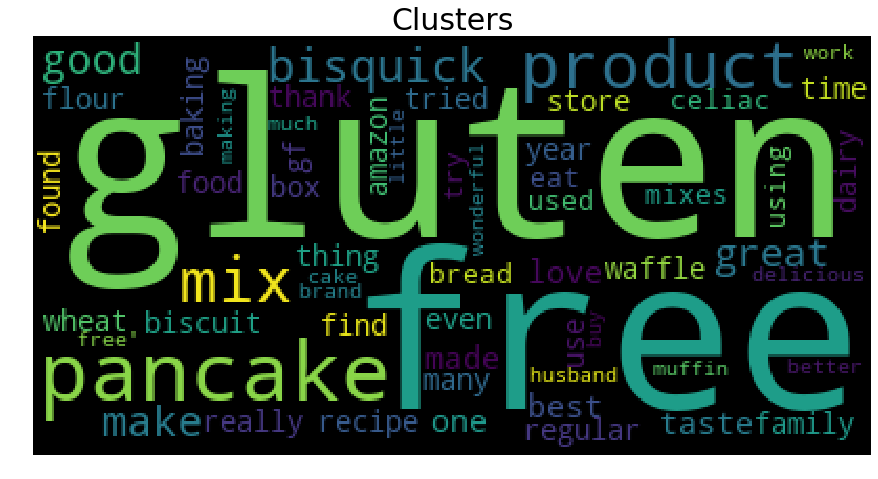

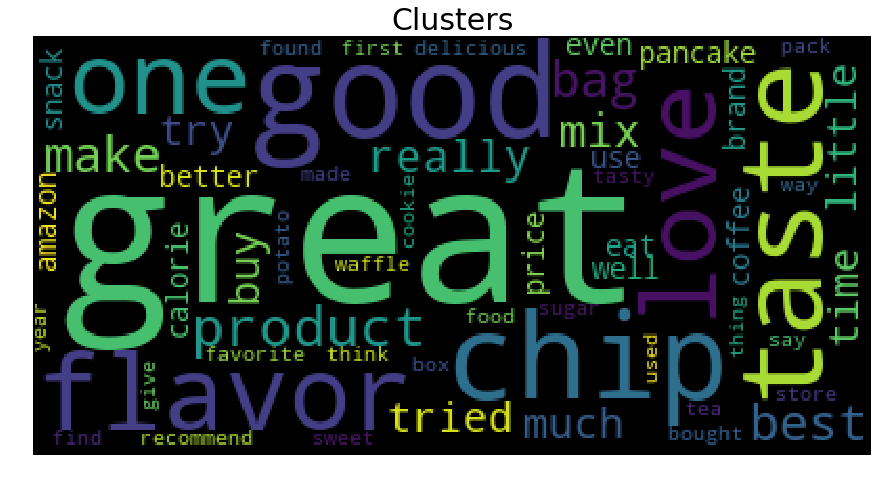

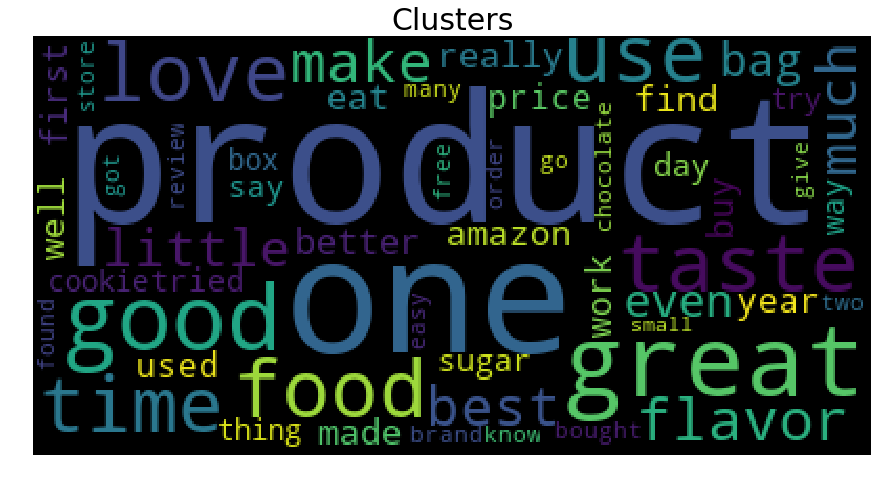

In [48]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit(sent_vectors)
clust_w2v = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_w2v[km.labels_[i]].append(preprocessed_reviews[i])
for cls in clust_w2v:
    cloud(cls)

# Observations

1..First cluster has words like hot, cup, tea, coffee etc so,we can say that the first cluster belongs to coffee and its varieties.

2.Second cluster has words like great, product,amazon, good etc so,we can say that the second cluster belongs 'Compliments for a good product'.

3.Third cluster has words like chip, best, great,potato etc so,we can say that the third cluster belongs to chips.

4.Fourth cluster has words like product, one, great,taste etc so,we can say that the fourth cluster belongs to compliments to a product.

5.Fifth cluster has words like taste, flavor, coffee, tea etc so,we can say that the fifth cluster belongs to hot drinks.

6.Sixth cluster has words like dog, love, food, organic etc so,we can say that the sixth cluster belongs to pet's food.

7.Seventh cluster has words like gluten, free, pancake, biscuit etc so,we can say that the seventh cluster belongs to types of  Bakery items.


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [49]:
# Please write all the code with proper documentation
k_vals = list(range(2, 50,5))
inertia_tfidf_w2v = []
for i in tqdm(k_vals):
    km = KMeans(n_clusters=i)
    km.fit( tfidf_sent_vectors)
    inertia_tfidf_w2v.append(km.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  2.02s/it]


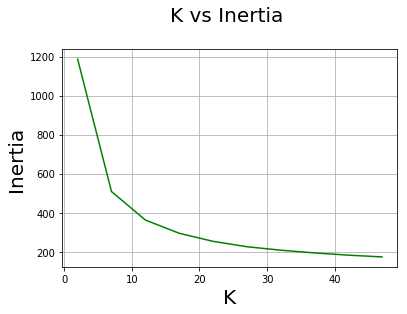

In [50]:
plt.plot(k_vals,inertia_tfidf_w2v,'g')
plt.grid(True)
plt.title("K vs Inertia \n",size=20)
plt.xlabel("K",size=20)
plt.ylabel("Inertia",size=20)
plt.show();

Using Elbow Method we can say that optimal alue of K is 7. Therefore we have 7 different clusters.

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

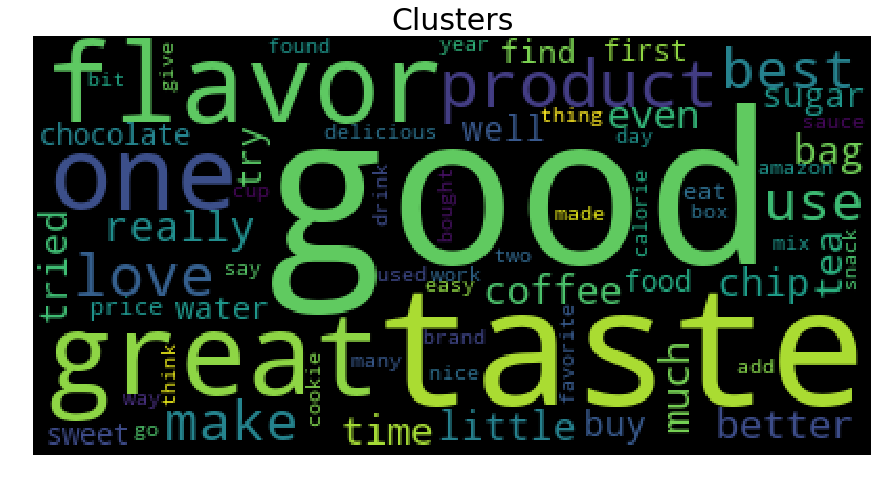

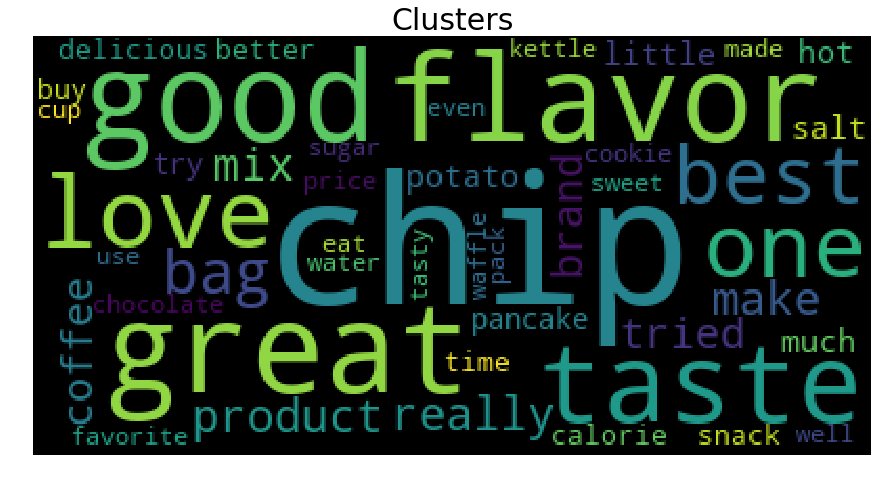

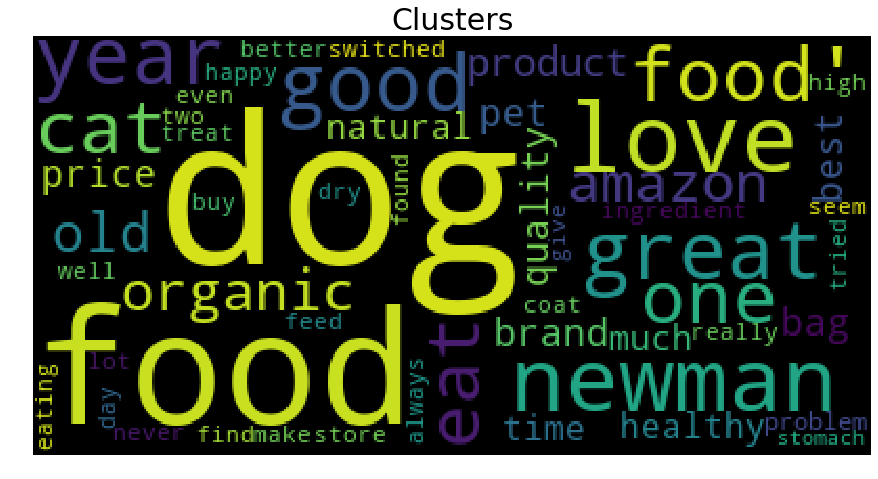

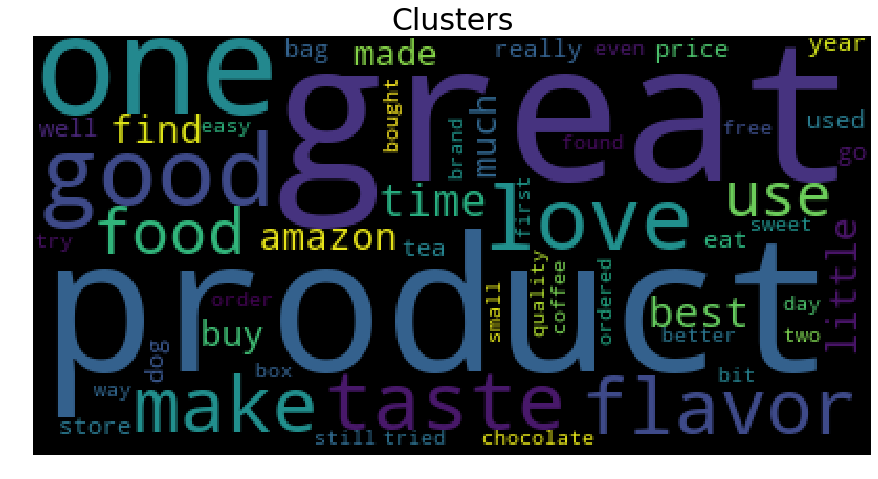

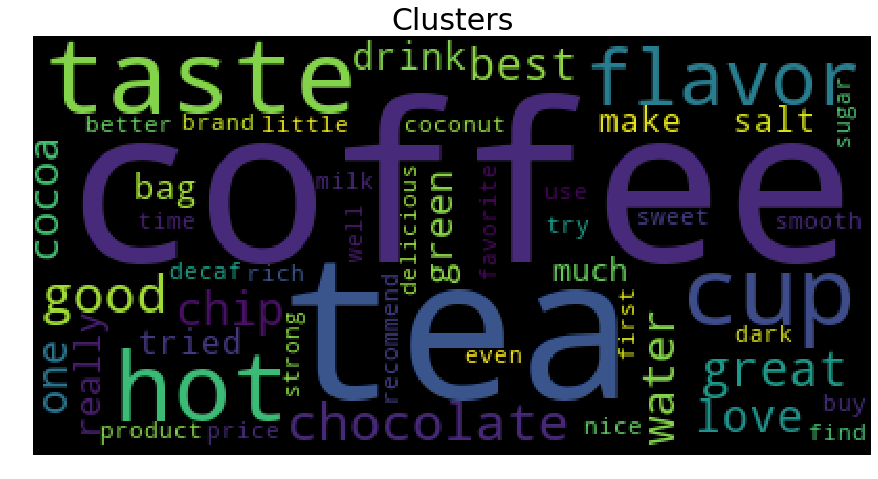

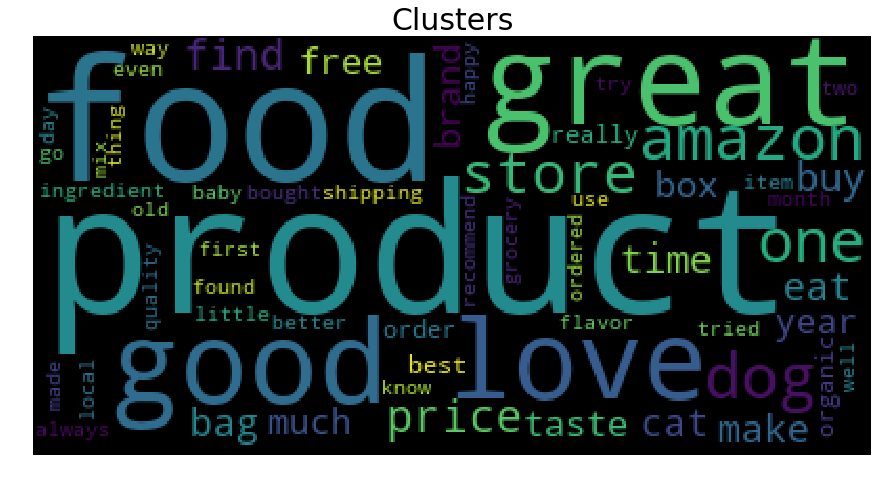

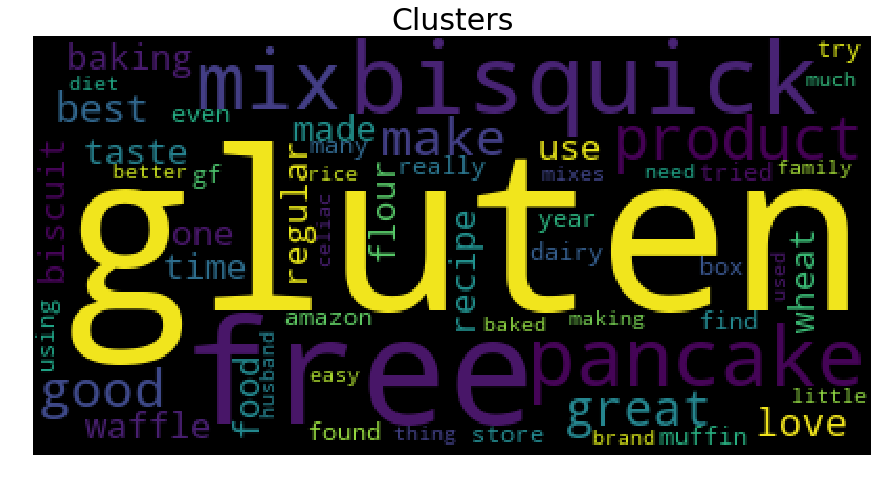

In [51]:
# Please write all the code with proper documentation
optimal_k = 7
km = KMeans(n_clusters=optimal_k).fit( tfidf_sent_vectors)
clust_tfidf_w2v = [ [] for i in range(optimal_k) ]   
for i in range(km.labels_.shape[0]):
    clust_tfidf_w2v[km.labels_[i]].append(preprocessed_reviews[i])
for cls in clust_tfidf_w2v:
    cloud(cls)

# Observations

1.First cluster has words like chip, best, great, potato etc so,we can say that the first cluster belongs to chips.

2.Second cluster has words like product, one, great,taste etc so,we can say that the second cluster belongs to compliments to a product.

3.Third cluster has words like great, product,amazon, good etc so,we can say that the third cluster belongs 'Compliments for a good product'.

4.Fourth cluster has words like taste, flavor, coffee, tea etc so,we can say that the fourth cluster belongs to hot drinks.

5.Fifth cluster has words like dog, love, food, organic etc so,we can say that the fifth cluster belongs to pet's food.

6.Sixth cluster has words like hot, cup, tea, coffee etc so,we can say that the sixth cluster belongs to coffee and its varieties.

7.Seventh cluster has words like gluten, free, pancake, biscuit etc so,we can say that the seventh cluster belongs to types of  Bakery items.


## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [52]:
from sklearn.cluster import AgglomerativeClustering

def all_agglo(n_clust):
    print("Clustering",n_clust," Clusters\n")
    agglo = AgglomerativeClustering(n_clusters=n_clust)
    agglo.fit(sent_vectors)
    clust = [ [] for i in range(n_clust) ]   
    for i in range(agglo.labels_.shape[0]):
        clust[agglo.labels_[i]].append(preprocessed_reviews[i])
    i = 1
    for cls in clust:
        cloud(cls)        

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Clustering 3  Clusters



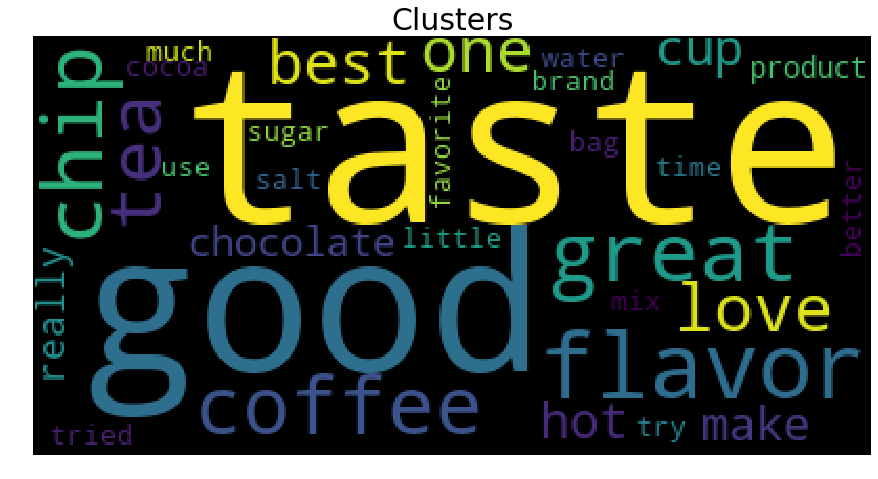

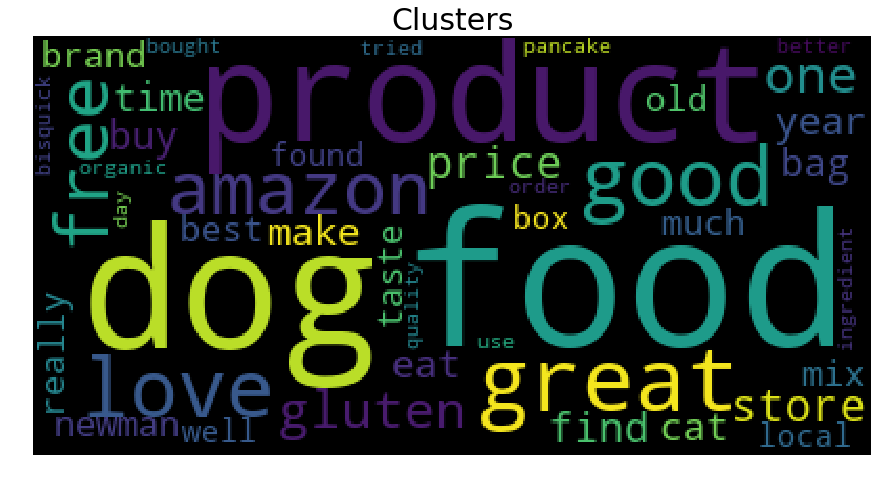

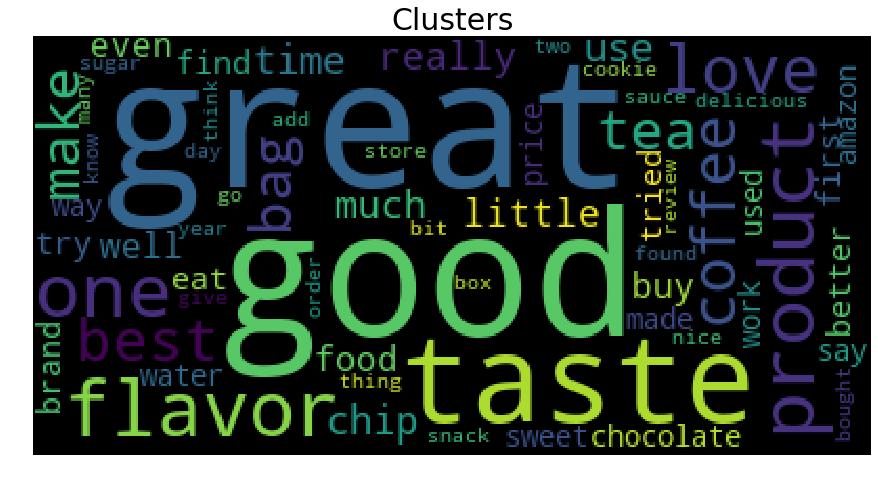

Clustering 5  Clusters



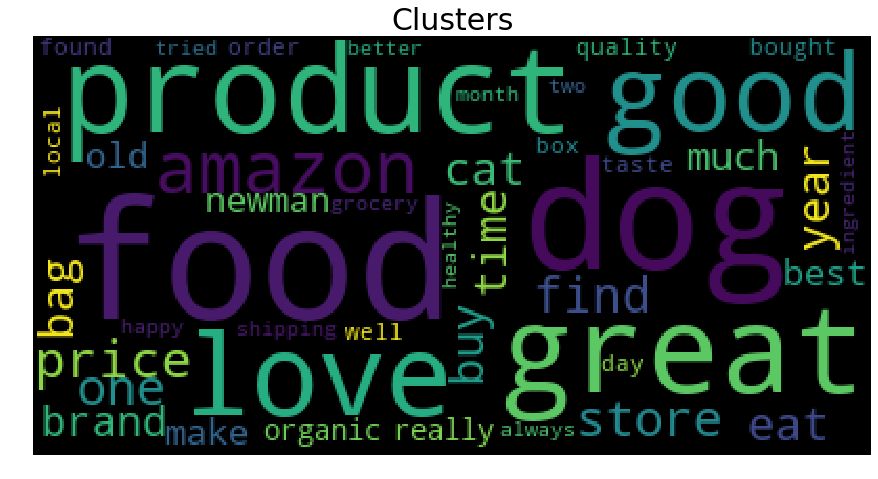

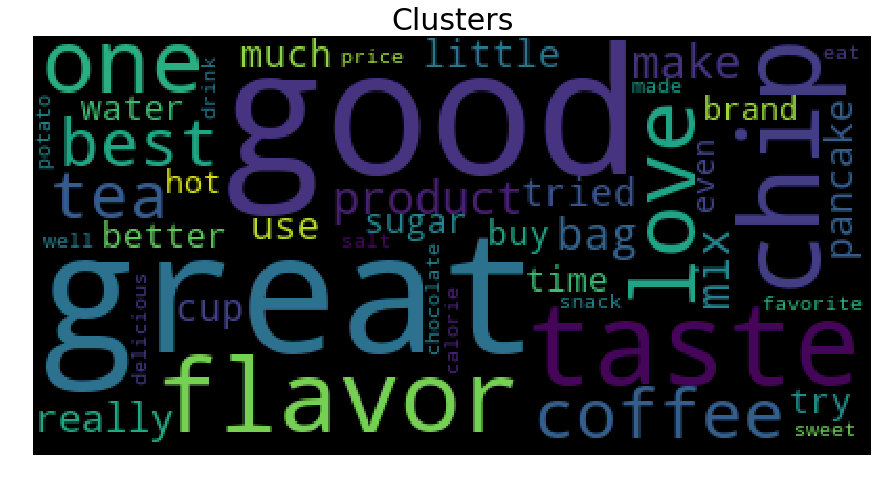

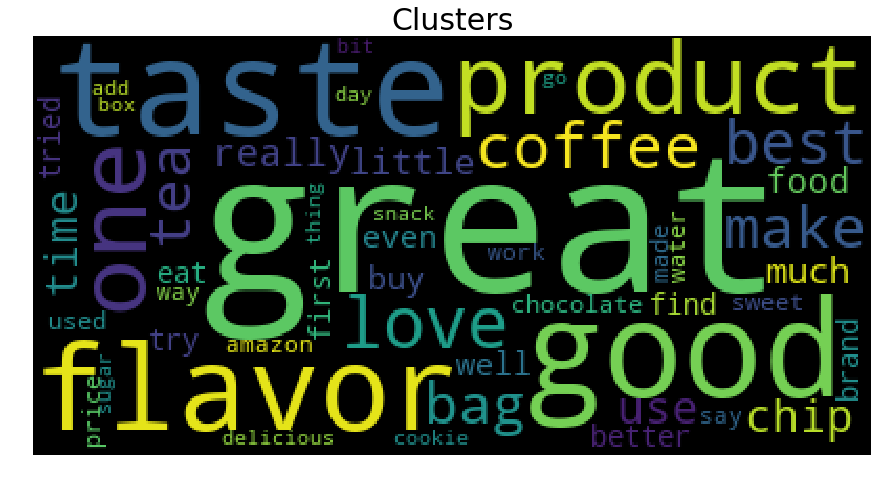

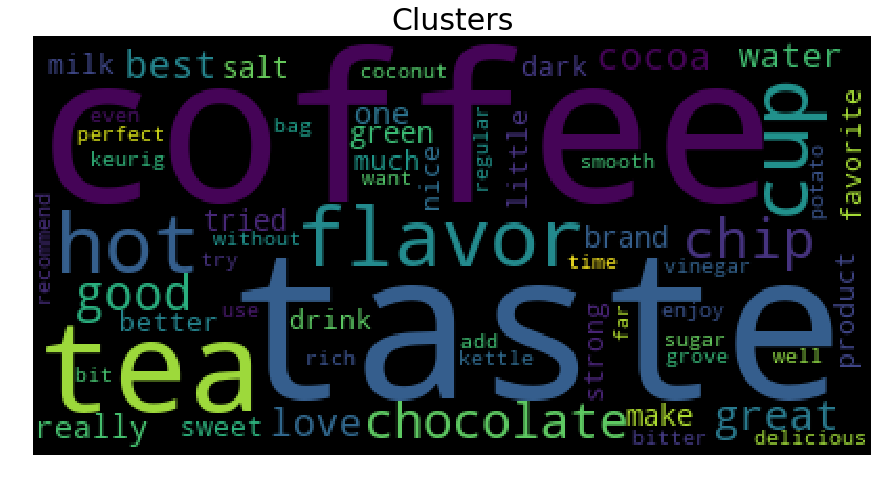

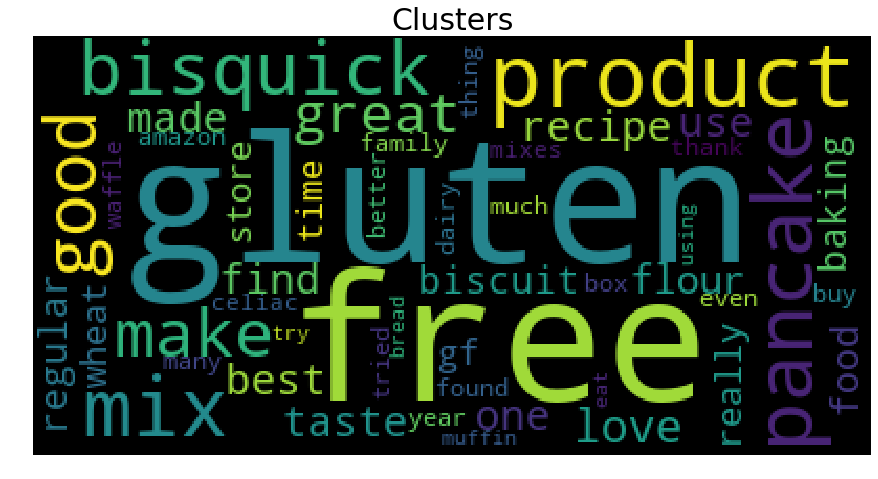

Clustering 7  Clusters



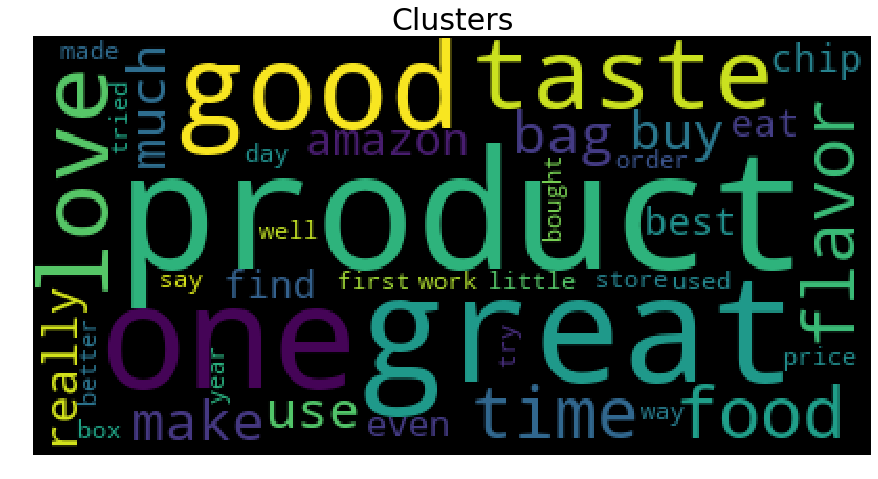

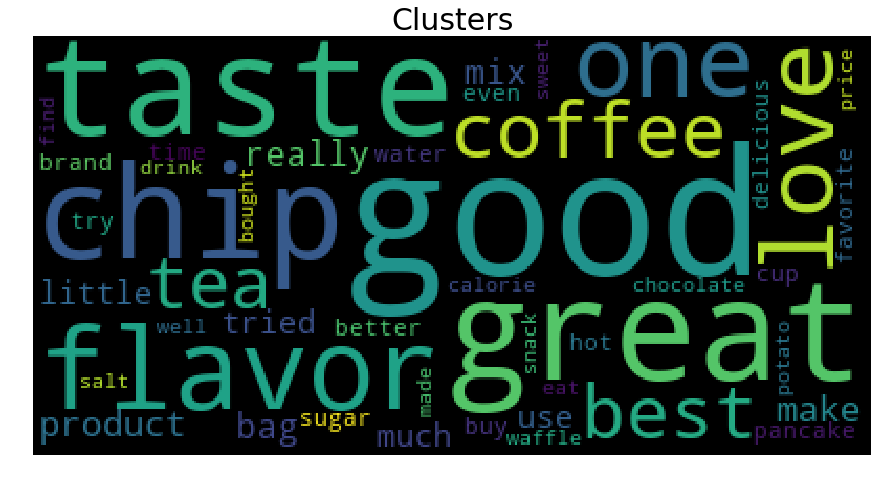

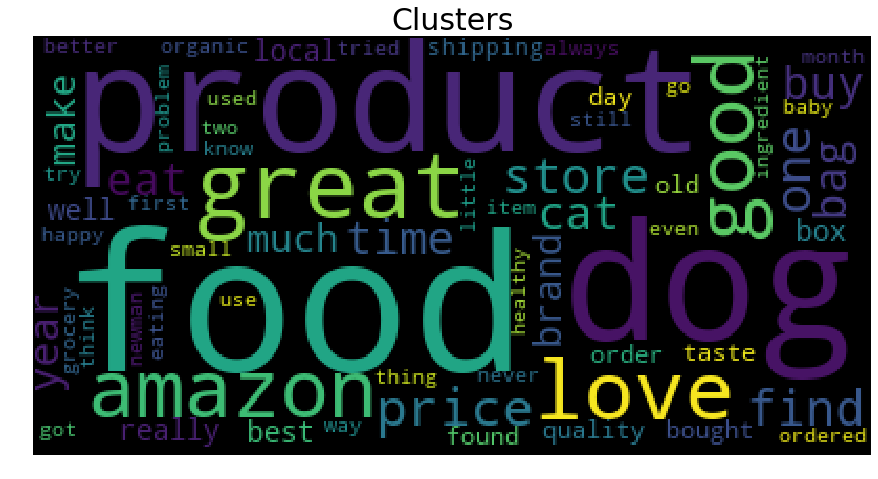

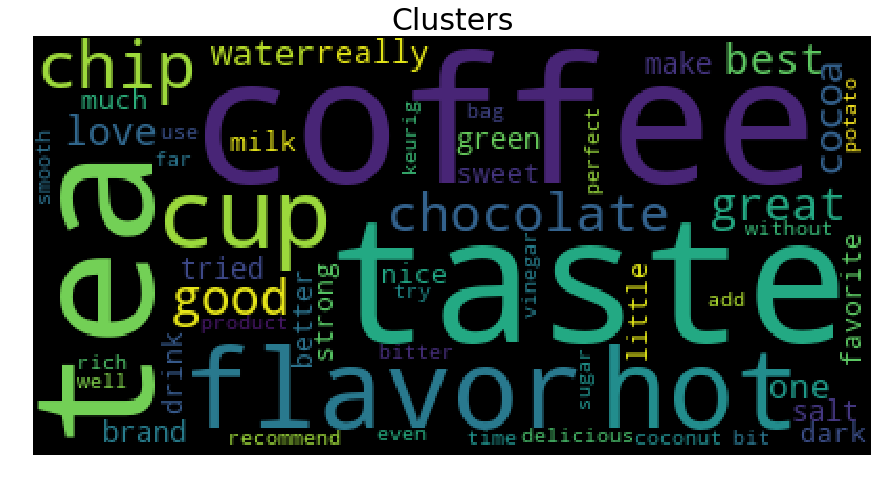

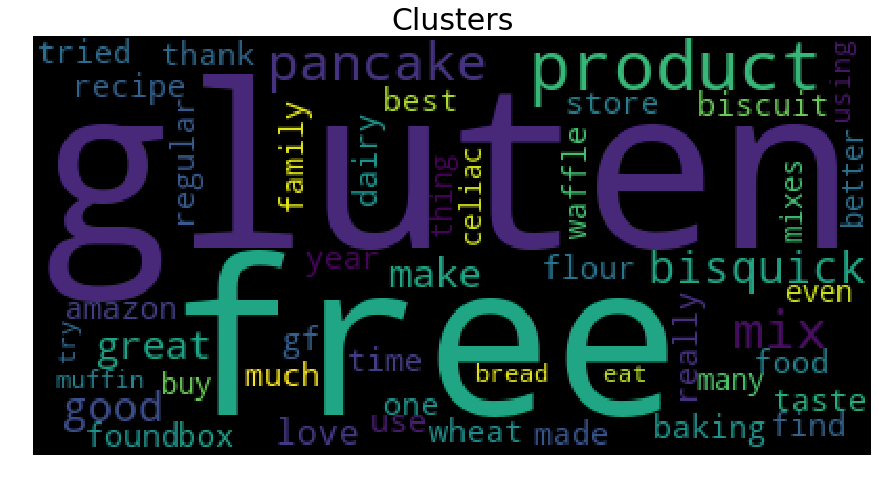

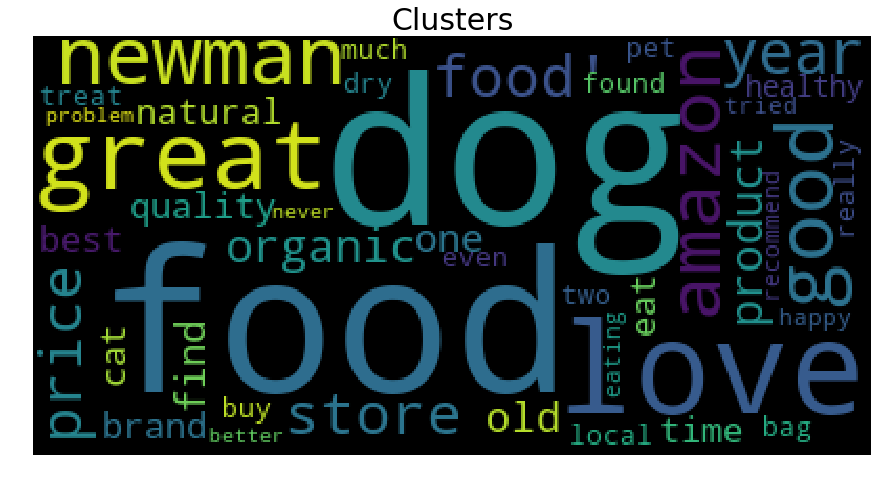

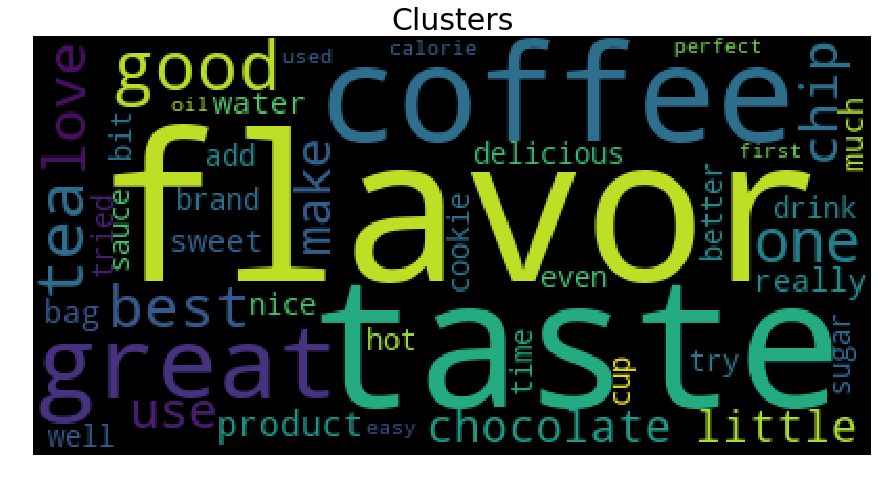

In [53]:
all_agglo(3)
all_agglo(5)
all_agglo(7)

# Observations

## 3 Clusters

1.First cluster belongs to chips.

2.Second belongs to hot drinks.

3.Third cluster belongs 'Compliments for a good product'.

## 5 Clusters

1.First cluster belongs to 'Compliments for a good food'.

2.Second belongs to coffee.

3.Third cluster belongs to bakery food.

4.Fourth cluster belongs to 'Compliments to Amazon for the convinient prices of products'.

5.Fifth cluster belongs to pet's food.

## 7 Clusters

1.First cluster belongs to 'Compliments to Amazon for the convinient prices of products'.

2.Second belongs to 'Compliments for a good food'.

3.Third cluster belongs to hot drinks.

4.Fourth cluster belongs to chips.

5.Fifth cluster belongs to pet's food.

6.Sixth cluster belongs to coffee and its varieties.

7.Seventh cluster belongs to types of Bakery items.


### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
def all_agg(n_clust):
    print("Clustering",n_clust," Clusters\n")
    agglo = AgglomerativeClustering(n_clusters=n_clust)
    agglo.fit(tfidf_sent_vectors)
    clusters = [ [] for i in range(n_clust)]   
    for i in range(agglo.labels_.shape[0]):
        clusters[agglo.labels_[i]].append(preprocessed_reviews[i])
    i = 1
    for cls in clusters:
        cloud(cls)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>


Clustering 2  Clusters



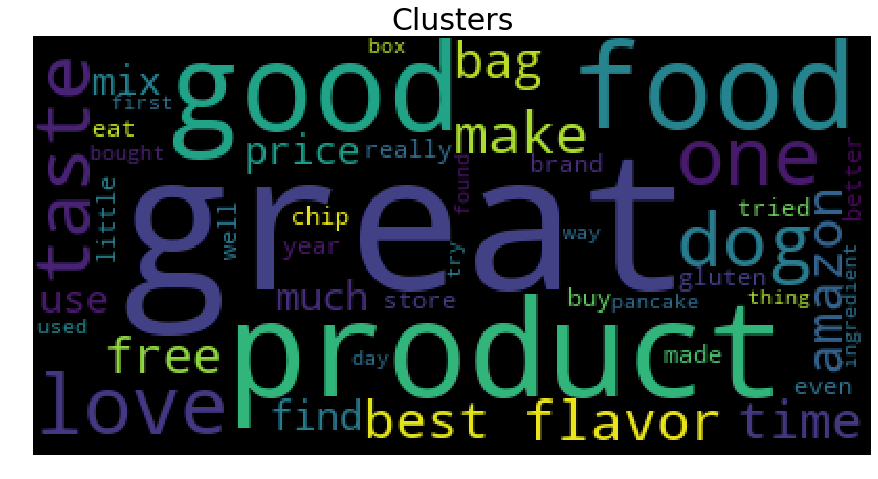

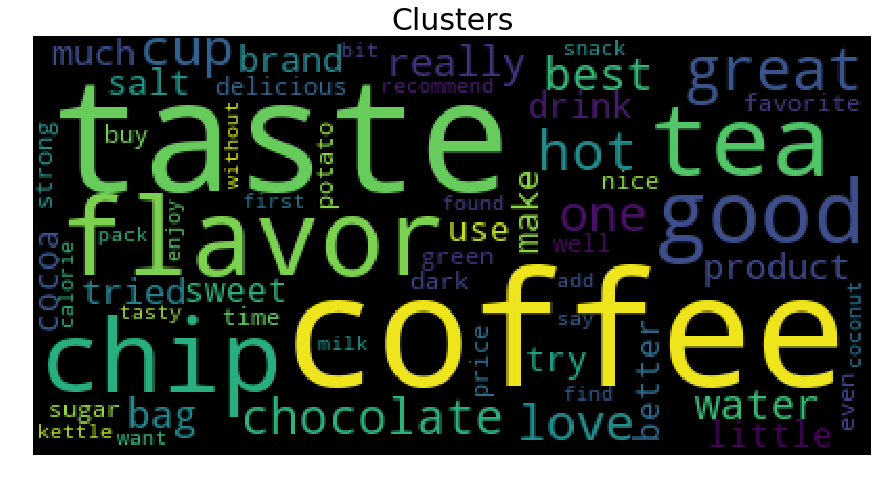

Clustering 3  Clusters



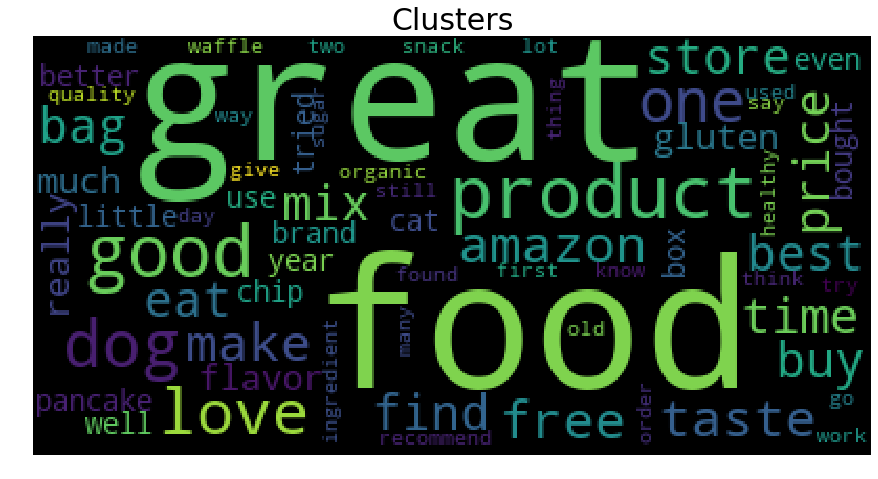

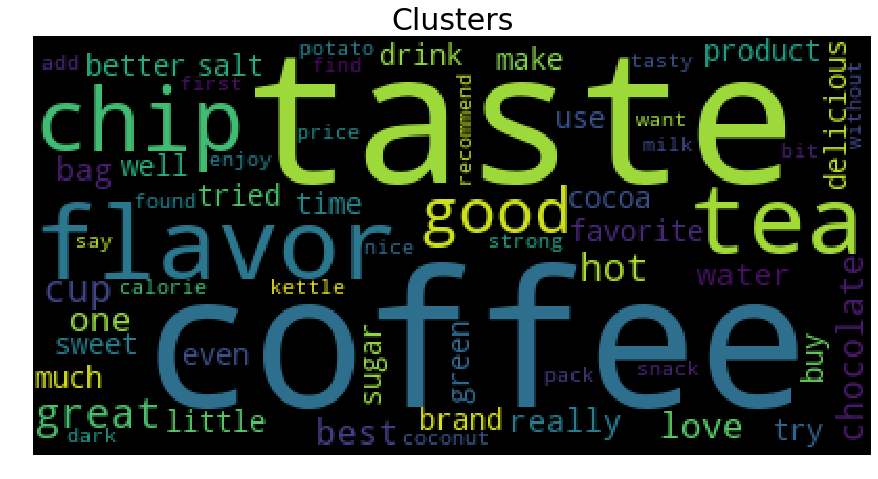

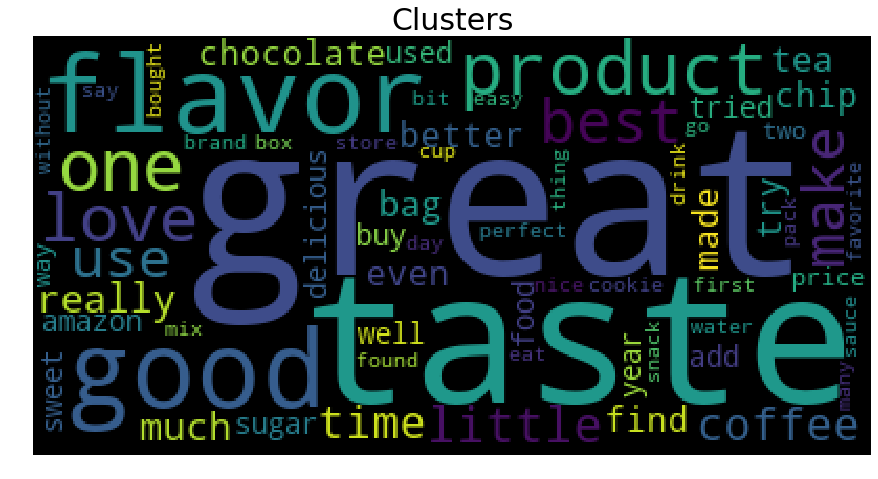

Clustering 5  Clusters



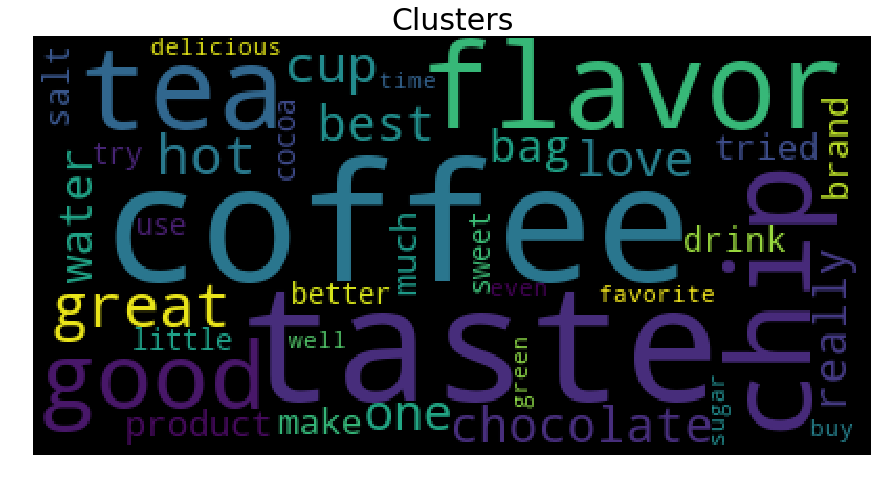

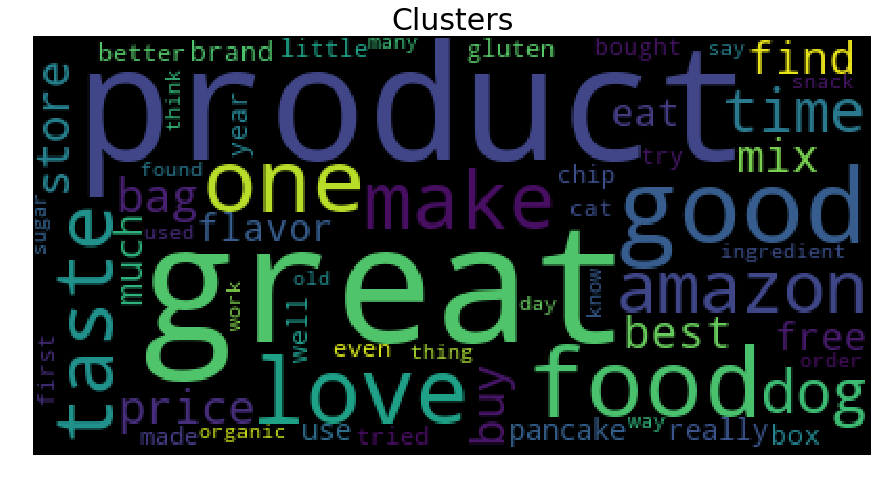

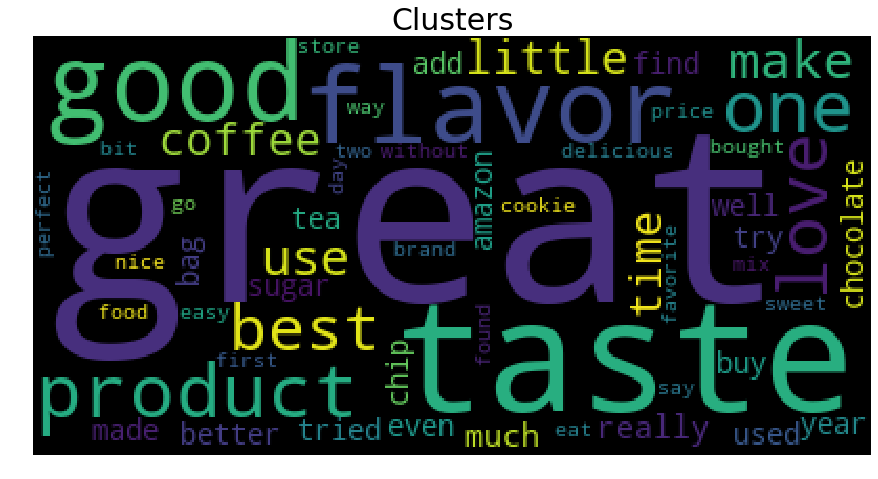

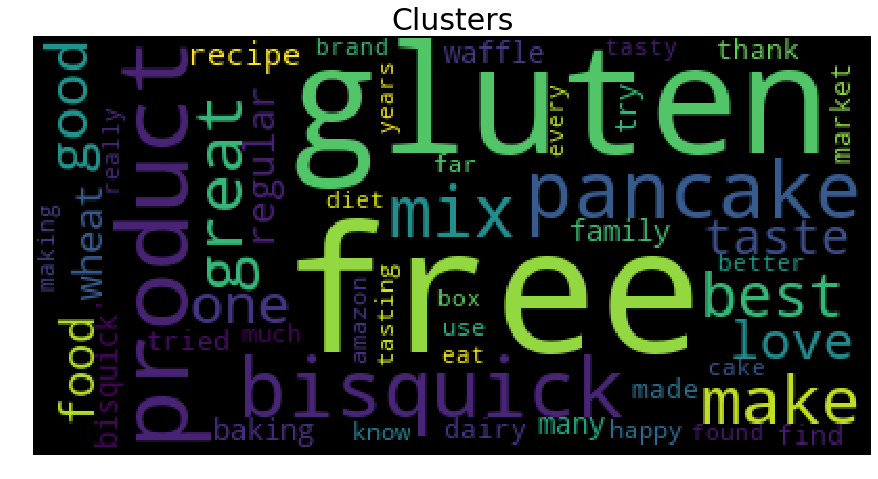

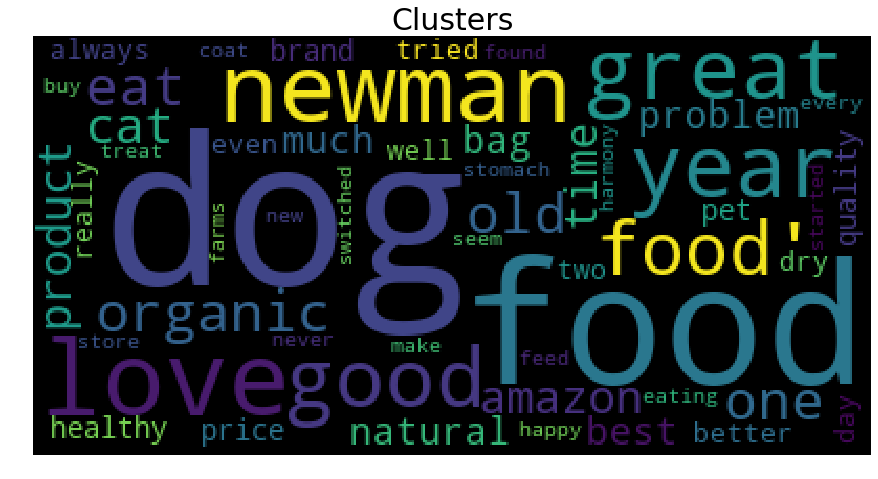

In [55]:
all_agg(2)
all_agg(3)
all_agg(5)

# Observations

## 2 Clusters

1.First cluster belongs to 'Compliments for a good food'.

2.Second belongs to chipss.

## 3 Clusters

1.First cluster belongs to 'Compliments for a good product'.

2.Second belongs to chips.

3.Third cluster belongs to coffee.

## 5 Clusters

1.First cluster belongs to pet's food. 

2.Second belongs to 'Compliments to Amazon for the convinient prices of products'.

3.Third cluster belongs to 'Compliments for a good food'. 

4.Fourth cluster belongs to chips.

5.Fifth cluster belongs to hot drinks.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [56]:
# Please write all the code with proper documentation
from sklearn.cluster import DBSCAN
def all_db(db,min_point):
     
    dist = []
    for x in tqdm(db):
        tmp = np.linalg.norm(db-x,axis=1)
        tmp = np.sort(tmp)
        dist.append(tmp[min_point])
    dist = np.sort(dist)
    plt.plot(dist)
    plt.grid(True)
    plt.ylabel("Distance")
    plt.title("eps Distances")
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:08<00:00, 576.06it/s]


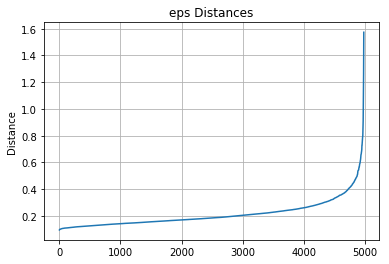

In [57]:
train_avgw2v = np.array(sent_vectors)
all_db(db=train_avgw2v,min_point= 2*train_avgw2v.shape[1])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Epsilon Value =  0.5


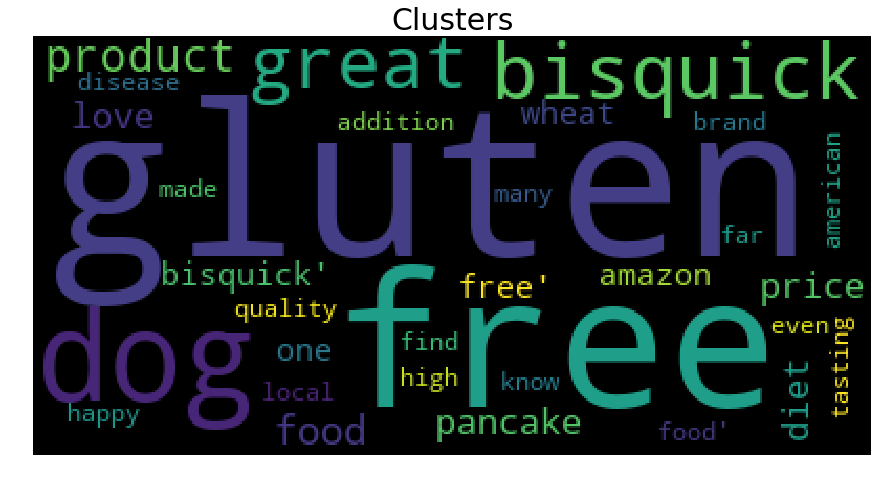

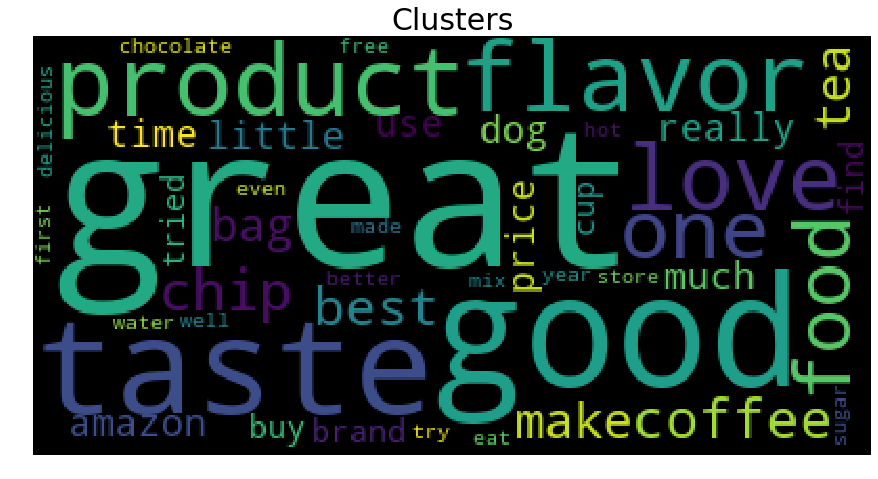

Epsilon Value =  0.6


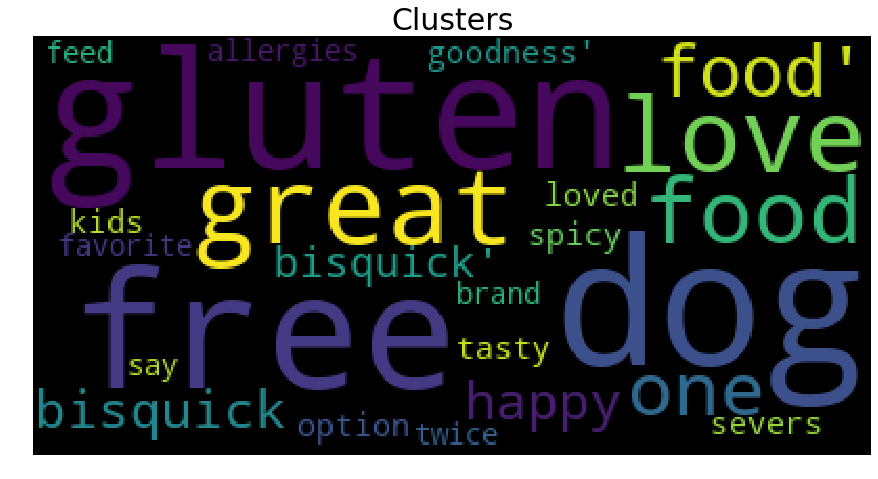

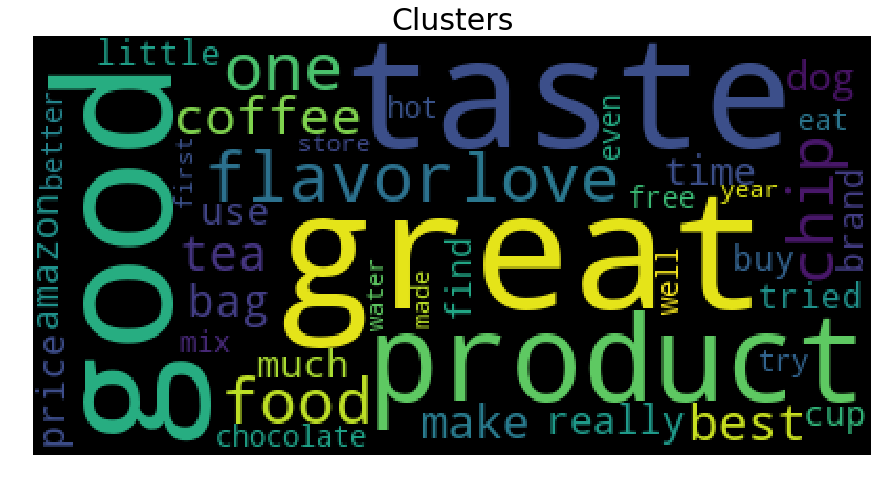

Epsilon Value =  0.7


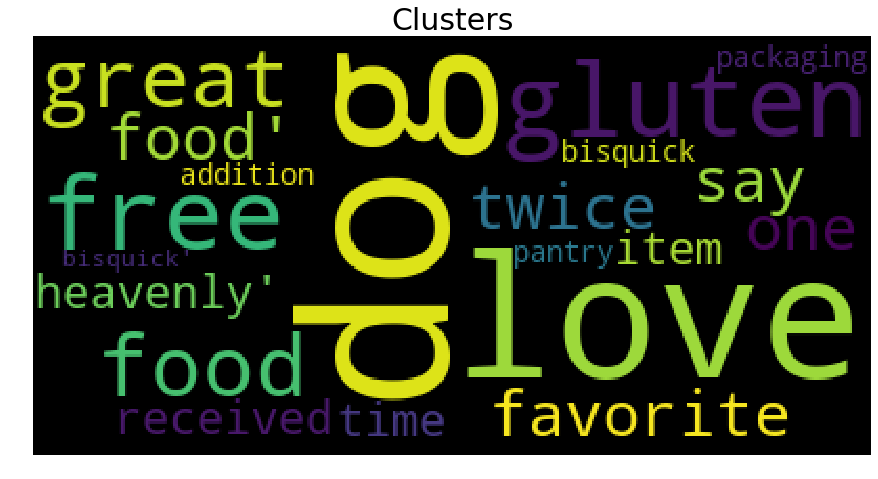

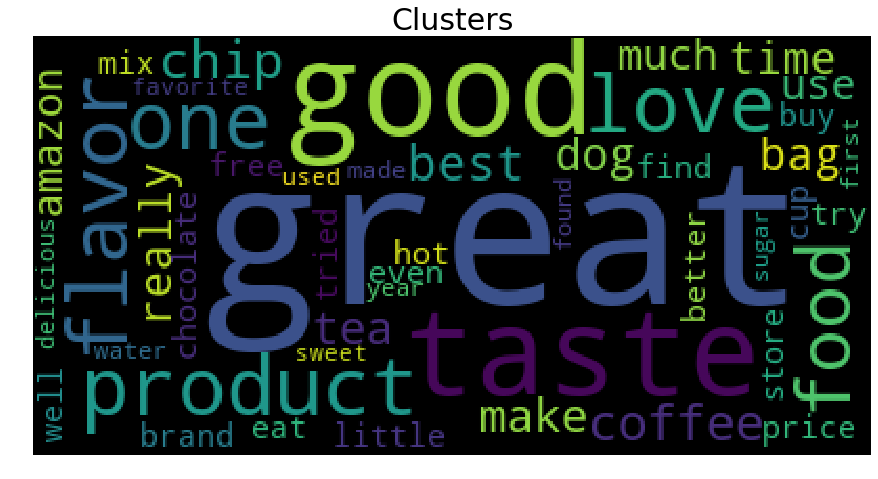

In [58]:
# Please write all the code with proper documentation

epsilon = [0.5,0.6,0.7]
for ep in epsilon:
    print("Epsilon Value = ",ep)
    db = DBSCAN(eps=ep, min_samples=2*train_avgw2v.shape[1])
    db.fit(train_avgw2v)
    labels = db.labels_ + 1 # to avoid -1 a for outliers
    clusters = [ [] for i in range(len(set(labels))) ]  # this is the list of clusters
    for i in range(labels.shape[0]):
        clusters[labels[i]].append(preprocessed_reviews[i])
    i = 1
    for cls in clusters:
        cloud(cls)

# Observations

## epsilon=0.5

1.First cluster belongs to 'gluten,'cookie','bread','brownie' and product related words like how good they are.

2.Second cluster belongs to taste,tea and related words.

## epsilon=0.6

1.First cluster belongs to taste of food.

2.Second cluster belongs to 'Compliments for a good food'.

## epsilon=0.7

1.First cluster belongs to 'Compliments for a good food'.

2.Second belongs to 'Compliments to Amazon for the convinient prices of products'.


### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [59]:
from sklearn.cluster import DBSCAN
def all_db(db,min_point):
     
    dist = []
    for x in tqdm(db):
        tmp = np.linalg.norm(db-x,axis=1)
        tmp = np.sort(tmp)
        dist.append(tmp[min_point])
    dist = np.sort(dist)
    plt.plot(dist)
    plt.grid(True)
    plt.ylabel("Distance")
    plt.title("eps Distances")
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:08<00:00, 570.09it/s]


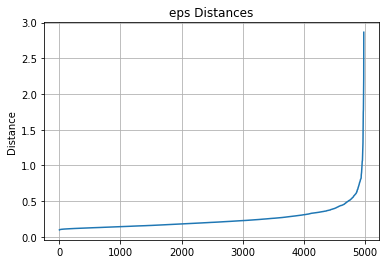

In [60]:
train_tfidfw2v = np.array(tfidf_sent_vectors)
all_db(db=train_tfidfw2v,min_point= 2*train_tfidfw2v.shape[1])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Epsilon Value =  0.5


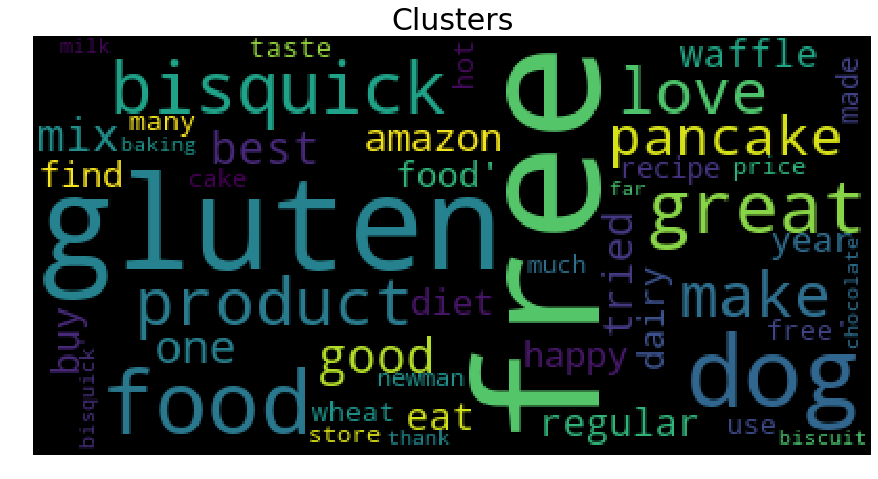

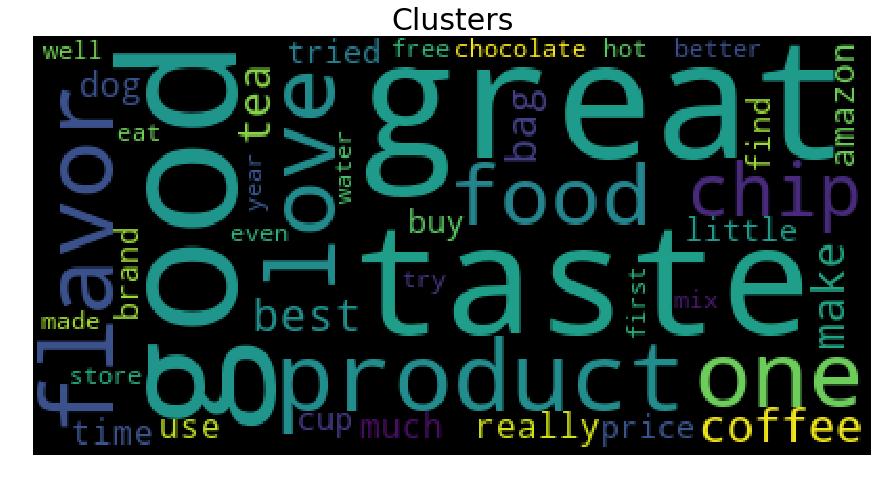

Epsilon Value =  0.6


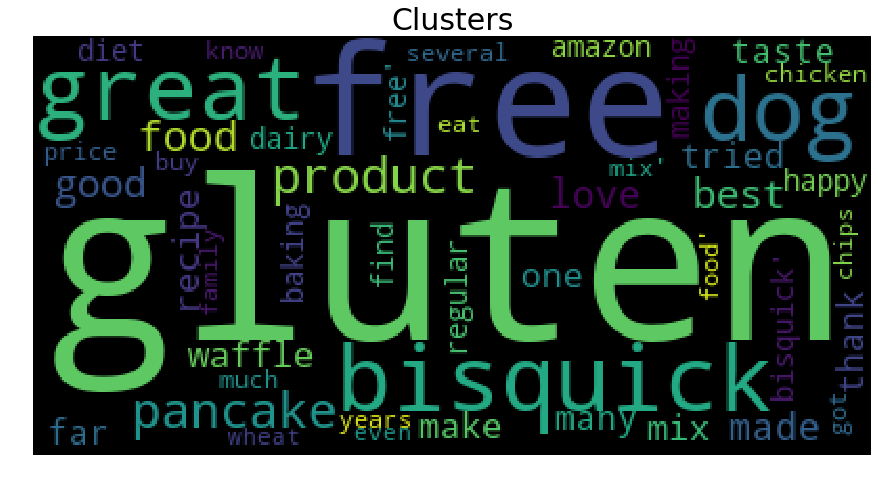

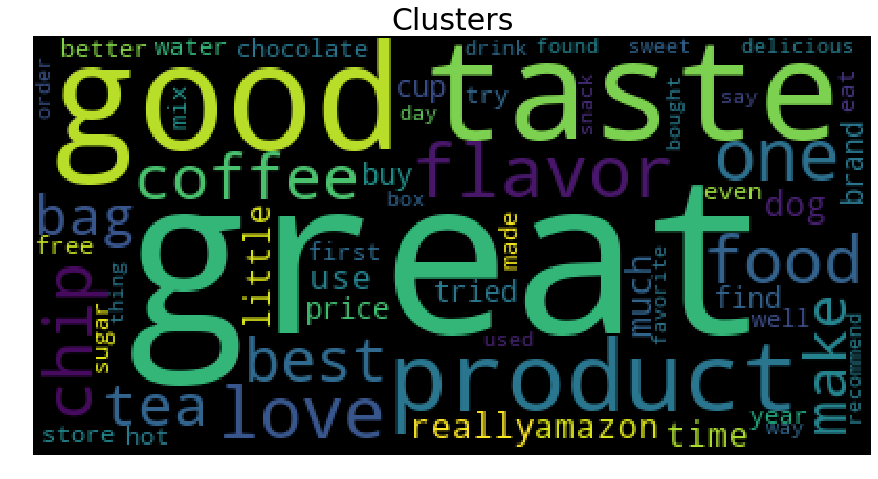

Epsilon Value =  0.7


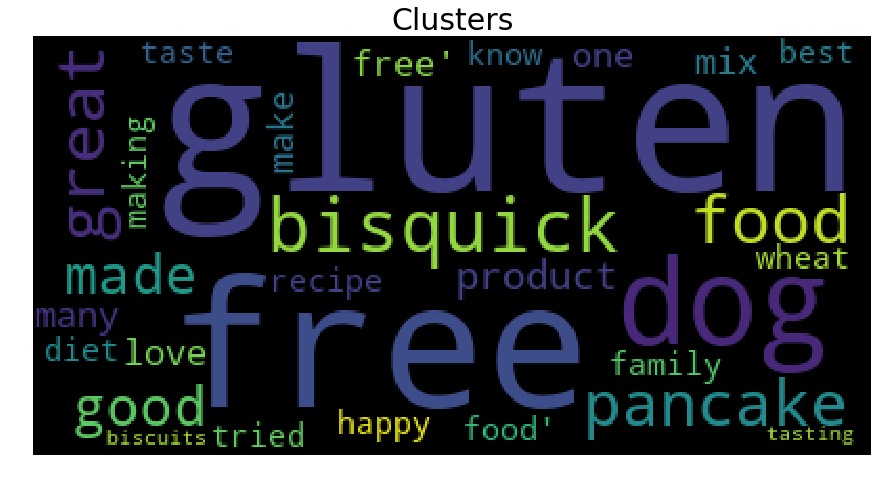

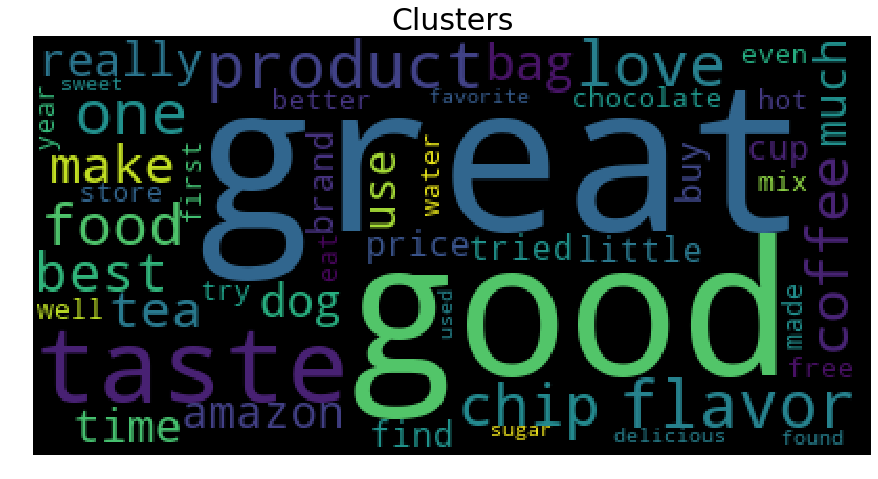

In [61]:
# Please write all the code with proper documentation
epsilon = [0.5,0.6,0.7]
for ep in epsilon:
    print("Epsilon Value = ",ep)
    db = DBSCAN(eps=ep, min_samples=2*train_tfidfw2v.shape[1])
    db.fit(train_tfidfw2v)
    labels = db.labels_ + 1 # to avoid -1 a for outliers
    clusters = [ [] for i in range(len(set(labels))) ]  # this is the list of clusters
    for i in range(labels.shape[0]):
        clusters[labels[i]].append(preprocessed_reviews[i])
    i = 1
    for cls in clusters:
        cloud(cls)      

# Observations

## epsilon=0.5

1.First cluster islated 'gluten', 'pancake', 'waffle', 'brownie' and product related words like how good or great it is

2.Second belongs to chip, good and tea related words.

## epsilon=0.6

1.First cluster belongs to taste of food.

2.Second cluster belongs to 'Compliments for a good food'.

## epsilon=0.7

1.First cluster belongs to 'Compliments for a good food'.

2.Second belongs to 'Compliments to Amazon for the convinient prices of products'.


# [6] Conclusions

In [62]:
from prettytable import PrettyTable

Vectorizer = ['Bag of Words','TFIDF','AVG W2V','TFIDF W2V']

kmeans=[7,7,7,7]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
print("             KMEANS                     ")
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
 
ptable.add_column("Kmeans",kmeans)
 
print(ptable)

             KMEANS                     
+-------+--------------+--------+
| S.NO. | Vectorizers  | Kmeans |
+-------+--------------+--------+
|   1   | Bag of Words |   7    |
|   2   |    TFIDF     |   7    |
|   3   |   AVG W2V    |   7    |
|   4   |  TFIDF W2V   |   7    |
+-------+--------------+--------+


In [63]:
Vectorizer = ['AVG W2V','TFIDF W2V']

agglo=[(3,5,7), (2,3,5) ]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
print("AGGLOMERATIVE HIERARCHICAL CLUSTERING")
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
 
ptable.add_column("Cluster Sizes",agglo)
 
print(ptable)

AGGLOMERATIVE HIERARCHICAL CLUSTERING
+-------+-------------+---------------+
| S.NO. | Vectorizers | Cluster Sizes |
+-------+-------------+---------------+
|   1   |   AVG W2V   |   (3, 5, 7)   |
|   2   |  TFIDF W2V  |   (2, 3, 5)   |
+-------+-------------+---------------+


In [64]:
Vectorizer = ['AVG W2V','TFIDF W2V']

eps=[0.5, 0.5]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
print('            DBSCAN')
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizers",Vectorizer)
ptable.add_column("Epsilon",eps)
print(ptable)

            DBSCAN
+-------+-------------+---------+
| S.NO. | Vectorizers | Epsilon |
+-------+-------------+---------+
|   1   |   AVG W2V   |   0.5   |
|   2   |  TFIDF W2V  |   0.5   |
+-------+-------------+---------+
